In [13]:
from generate_data import Data
from evaluate import *
from models import *


from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import shap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define el dispositivo que PyTorch usará para ejecutar los cálculos.
experiment_name = "interop_1"


# **Filtro 1 - 5% subset**

In [15]:
%%time
data = Data(layer_size=16)
train, val, test = data.get_splits(['random_subsample'], [[0.05, 0.95]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Number of samples: 198 train | 754 val | 3017 test
CPU times: total: 750 ms
Wall time: 746 ms


In [16]:
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))

C:\Users\franm\AppData\Local\Temp\ipykernel_21452\3401100232.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_cnn_model.load_state_dict(torch.load('./bestmodels/best

<All keys matched successfully>

# **SHAPKERNEL for LSTM**

In [28]:
feature_names_mapped = [
    data.feature_names_one_hotted[i] if i < len(data.feature_names_one_hotted) else f"feature_{i}"
    for i in range(384)
]

Definimos la funcion de predict y el explainer

In [21]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_SHAP_LSTM(x_train):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_lstm_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Explicacion generada por SHAP


Generando explicación para clase 'A'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['__,..,.,_._,_...', ',___,_..__,,,.uw', '____._.._._,,,dr', 'A']
  Muestra 2: [',.._,_,._._.,.,.', '..._uw...,_,_,,.', '_dr,_,._,,...._,', 'A']
  Muestra 3: [',.._,.___.,.__,.', '.,.,,_..,_.uw..,', ',._..,.,__dr._,,', 'A']
  Muestra 4: ['_.._,_,,_._,_.,.', '.uw._,._.._..._,', ',.__.,,_dr_.,...', 'A']
  Muestra 5: [',_.,.__._,,__,_,', '.,_.__,..,_,_uw.', ',_....__..._dr_.', 'A']
  Muestra 6: ['__,__,._.___,,,.', '__._,uw_____._._', ',,___.___.dr,._.', 'A']
  Muestra 7: [',,,_,,..,,,,._,.', ',,_,_._,.._.,_uw', '.,dr,..,.,.__,__', 'A']
  Muestra 8: ['.,,____,._.,_,_,', '_,_uw_,,,_,_.,,,', '_dr,,_.,..._..,,', 'A']
  Muestra 9: [',...__...,..,__,', ',__uw_._.,,_._..', '__.,,,_,...,..dr', 'A']
  Muestra 10: [',.,_,,_,_,._.,__', ',_uw.,.._......_', '_dr_,,.,_,_,,._.', 'A']


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
C:\Users\franm\AppData\Local\Temp\ipykernel_21452\345015828.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(class_shap_values, x_subset, feature_names=feature_names_mapped)


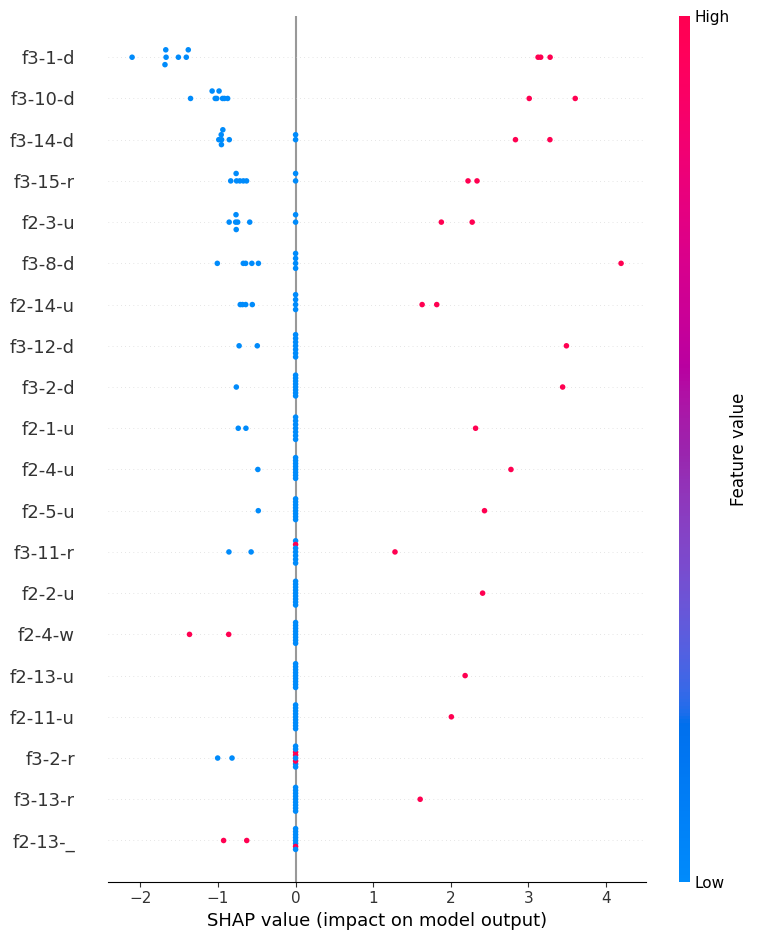


Generando explicación para clase 'D'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['._._.._.__,..,,,', '_,_,_.,.__.w___.', '_,_,dr,__._.....', 'D']
  Muestra 2: [',,.__,_._.._..,_', ',,__,.,,.,.._,__', ',.,,,,..,.,,dr..', 'D']
  Muestra 3: ['_,._,,,_,._..,,,', '__.._.__,__.,w,.', '.,_.,__,..._dr_,', 'D']
  Muestra 4: [',,_.__,_,____,__', '._.___.,.w_,,,__', '_,,.dr.____,_,__', 'D']
  Muestra 5: ['._,_,,_,.,,._._.', ',...._,_.,___,..', '.dr_.__.,..,,.__', 'D']
  Muestra 6: ['.,____.._,_.,,..', ',,.__,.,,w,,_,,_', ',,,___,.dr,..,,,', 'D']
  Muestra 7: ['.___._.._...,.,.', '..,_.__,,_.,._,.', 'dr_...,__..,._.,', 'D']
  Muestra 8: ['.,,_.._,.,._,_,,', '..____,w...,,.,,', '_,,dr,,,..,,..__', 'D']
  Muestra 9: ['_,_,,,_...__,,,.', ',..,.,___.._,,.,', ',___._,,._dr,,..', 'D']
  Muestra 10: ['._.._,.,_,,._,_.', '_,.,__...__,.,,,', '._,,,___dr..__._', 'D']


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


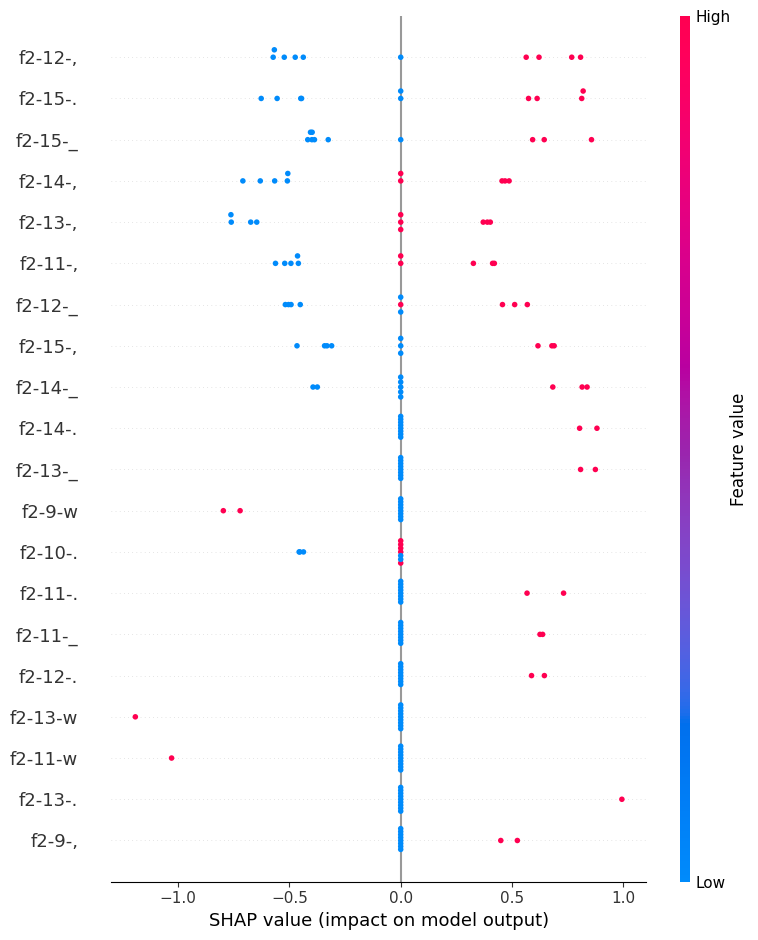


Generando explicación para clase 'R'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['_,,.,..._,._.___', ',._wu.,.,,.__.,_', '__._,,_..r.,,,.,', 'R']
  Muestra 2: [',,__.,_,_.._._,_', ',_,,._.w,___.,_,', ',,,_,,r_,...,,,_', 'R']
  Muestra 3: ['.__,_,_._,.,..,,', ',...._...uw_,__,', '._,r,_,.._,,_.,_', 'R']
  Muestra 4: ['___,___,,,_,_.,.', '_.____.._,,.,.__', '..._..r,._,.,_,.', 'R']
  Muestra 5: ['__..,_._,._._..,', ',.,_.,uw._._,...', ',r__,__,.,,.,__,', 'R']
  Muestra 6: ['._,.,.,...,_.._.', 'wu__.,,,,,_._.._', '___r_..__,.,,_,.', 'R']
  Muestra 7: ['...,_.._..__,,_.', '_._,,_..,,,_..,_', '.r,_.____,._,...', 'R']
  Muestra 8: ['.,_,._,,_...._._', ',,.,,....,,___.,', '__,_,__.,.._r_..', 'R']
  Muestra 9: ['_.,,_..,___,,_._', '.,.__w_.,_.._,,_', '...,_.._r,_,._,.', 'R']
  Muestra 10: ['_,._,..,__,.._..', ',,,.,...__.,.._,', '.,...,.r,,._,,..', 'R']


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


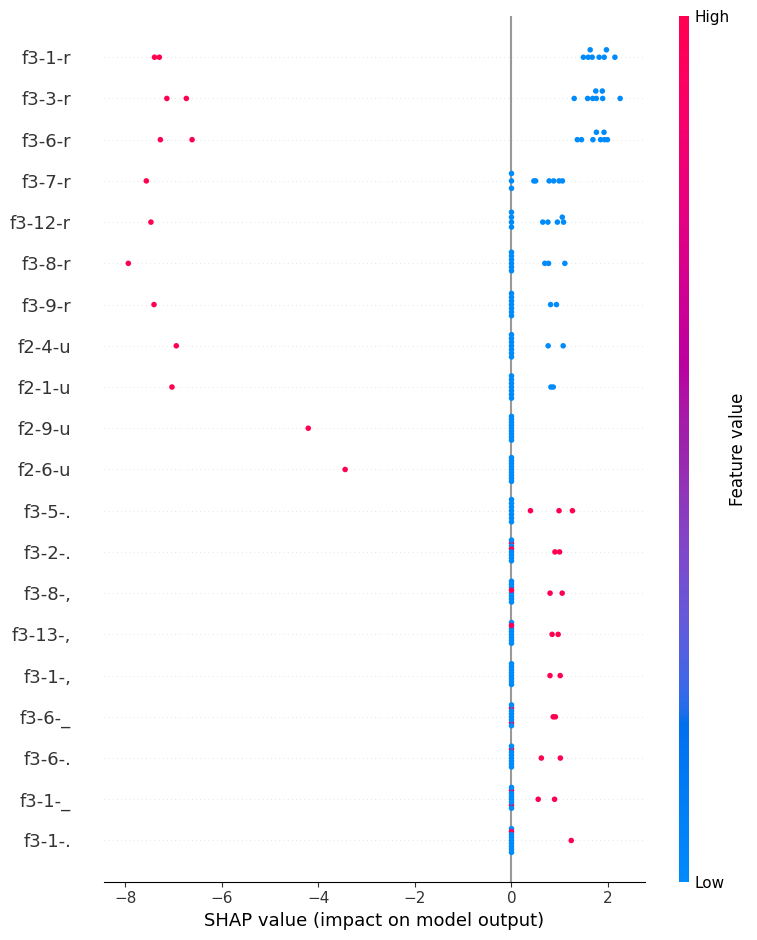


Generando explicación para clase 'V'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['_,_.,_,__,,.._,.', ',.,,.,,,wu_.,...', '.,_._,__._,__.._', 'V']
  Muestra 2: ['..,,,,.__._.,.._', 'wu,..,..,..__,,.', 'cr.,._.....,._._', 'V']
  Muestra 3: [',..,_,,..,_,__..', '..__,,,.,._.,._,', '_.,._,..cr_..._.', 'V']
  Muestra 4: [',,_,.,_,._.___,_', 'w,,,.._..._,_,,_', '._.,._.,._.__.__', 'V']
  Muestra 5: ['._..,_.__.,,.,..', '._._,.._,,_,.wu,', 'cr,_,,.___.,__..', 'V']
  Muestra 6: ['_,.._..,,.,_,_,.', '.,_.,_,wu__,.___', 'dr_,.__,_,._,,_.', 'V']
  Muestra 7: ['_,..,_,_,.,,,.,.', '_,__.._.,,.wu,._', ',...,.._.,_...,_', 'V']
  Muestra 8: ['._,._.___,,,._..', ',,____,,._,___,.', ',.._,,.,.,_,.,_.', 'V']
  Muestra 9: ['_..._,,,.,,,,,.,', '_.._.,_w,,___,_,', '_,_,,_.,..._.,,.', 'V']
  Muestra 10: ['._,.,_.,.,,.__._', '__,._,_,uw__,,.,', '_,_,._cr_,,..,..', 'V']


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


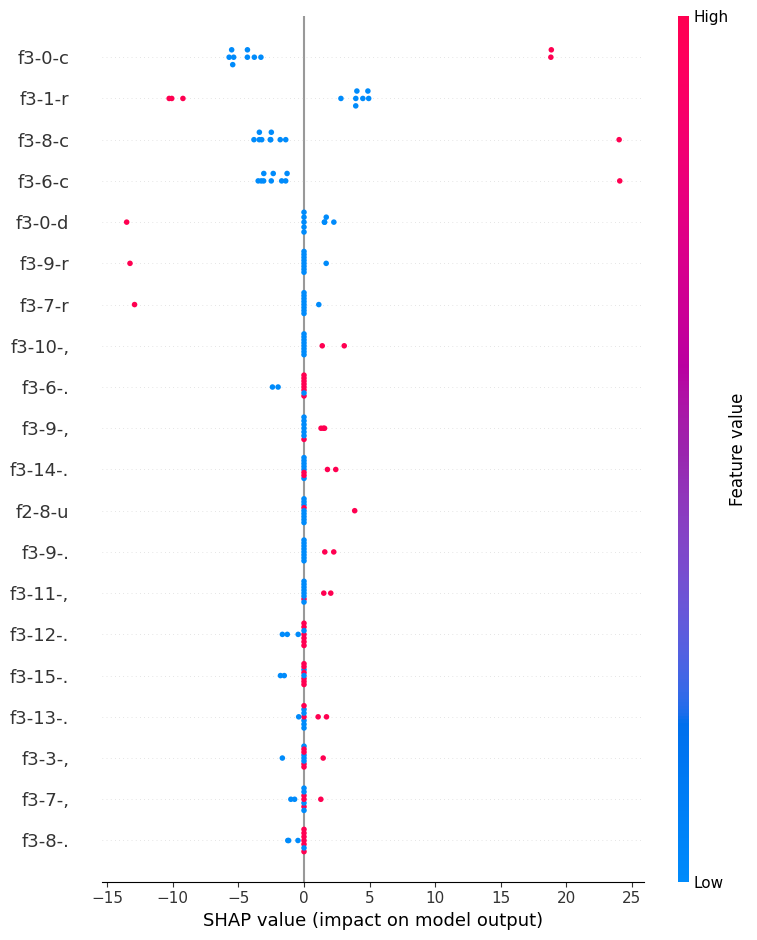

In [33]:
import shap
import numpy as np

# 💡 Nombres de clases
class_names = ["A", "D", "R", "V"]
n_samples = 10  # Número de muestras por clase

for class_idx in range(4):
    class_name = class_names[class_idx]
    print(f"\n==============================")
    print(f"Generando explicación para clase '{class_name}'")
    print(f"==============================")

    # 🟢 Buscar muestras de la clase en el conjunto de test
    indices = np.where(y_test == class_idx)[0][:n_samples]
    x_subset = x_test[indices]

    print(f" Muestras pasadas al explainer: {x_subset.shape}")
    print(f" Muestras pasadas al explainer (decodificadas):")
    for i, idx in enumerate(indices):
        print(f"  Muestra {i+1}: {test_original[idx]}")

    #  Crear el explainer con muestras solo de esa clase
    explainer = shap.KernelExplainer(predict_fn_SHAP_LSTM, x_subset)

    #  Explicamos las mismas muestras del test
    shap_values = explainer.shap_values(x_subset)

    #  SHAP de la clase actual
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(n_samples)])

    #  Mostrar resumen
    shap.summary_plot(class_shap_values, x_subset, feature_names=feature_names_mapped)


# **SHAPKERNEL para CNN**

Definimos la funcion predict y el explainer

In [34]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_SHAP_CNN(x_train):
    best_cnn_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_conv_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_cnn_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Explicacion generada por SHAP


Generando explicación para clase 'A'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['__,..,.,_._,_...', ',___,_..__,,,.uw', '____._.._._,,,dr', 'A']
  Muestra 2: [',.._,_,._._.,.,.', '..._uw...,_,_,,.', '_dr,_,._,,...._,', 'A']
  Muestra 3: [',.._,.___.,.__,.', '.,.,,_..,_.uw..,', ',._..,.,__dr._,,', 'A']
  Muestra 4: ['_.._,_,,_._,_.,.', '.uw._,._.._..._,', ',.__.,,_dr_.,...', 'A']
  Muestra 5: [',_.,.__._,,__,_,', '.,_.__,..,_,_uw.', ',_....__..._dr_.', 'A']
  Muestra 6: ['__,__,._.___,,,.', '__._,uw_____._._', ',,___.___.dr,._.', 'A']
  Muestra 7: [',,,_,,..,,,,._,.', ',,_,_._,.._.,_uw', '.,dr,..,.,.__,__', 'A']
  Muestra 8: ['.,,____,._.,_,_,', '_,_uw_,,,_,_.,,,', '_dr,,_.,..._..,,', 'A']
  Muestra 9: [',...__...,..,__,', ',__uw_._.,,_._..', '__.,,,_,...,..dr', 'A']
  Muestra 10: [',.,_,,_,_,._.,__', ',_uw.,.._......_', '_dr_,,.,_,_,,._.', 'A']


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]
C:\Users\franm\AppData\Local\Temp\ipykernel_21452\2426225975.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(class_shap_values_cnn, x_subset_cnn, feature_names=feature_names_mapped)


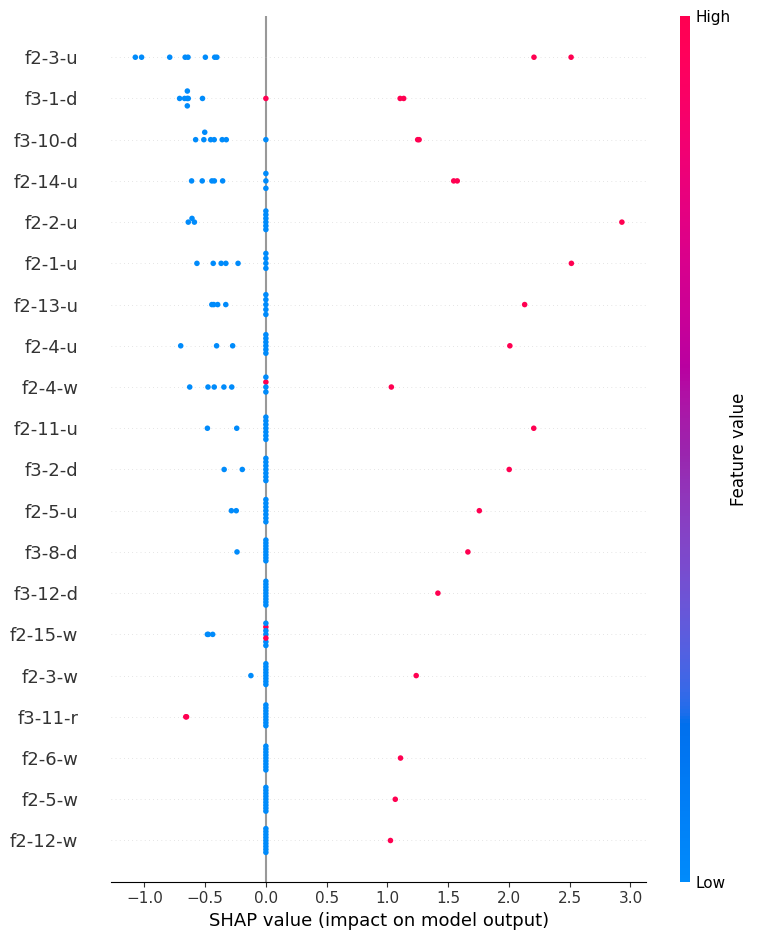


Generando explicación para clase 'D'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['._._.._.__,..,,,', '_,_,_.,.__.w___.', '_,_,dr,__._.....', 'D']
  Muestra 2: [',,.__,_._.._..,_', ',,__,.,,.,.._,__', ',.,,,,..,.,,dr..', 'D']
  Muestra 3: ['_,._,,,_,._..,,,', '__.._.__,__.,w,.', '.,_.,__,..._dr_,', 'D']
  Muestra 4: [',,_.__,_,____,__', '._.___.,.w_,,,__', '_,,.dr.____,_,__', 'D']
  Muestra 5: ['._,_,,_,.,,._._.', ',...._,_.,___,..', '.dr_.__.,..,,.__', 'D']
  Muestra 6: ['.,____.._,_.,,..', ',,.__,.,,w,,_,,_', ',,,___,.dr,..,,,', 'D']
  Muestra 7: ['.___._.._...,.,.', '..,_.__,,_.,._,.', 'dr_...,__..,._.,', 'D']
  Muestra 8: ['.,,_.._,.,._,_,,', '..____,w...,,.,,', '_,,dr,,,..,,..__', 'D']
  Muestra 9: ['_,_,,,_...__,,,.', ',..,.,___.._,,.,', ',___._,,._dr,,..', 'D']
  Muestra 10: ['._.._,.,_,,._,_.', '_,.,__...__,.,,,', '._,,,___dr..__._', 'D']


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


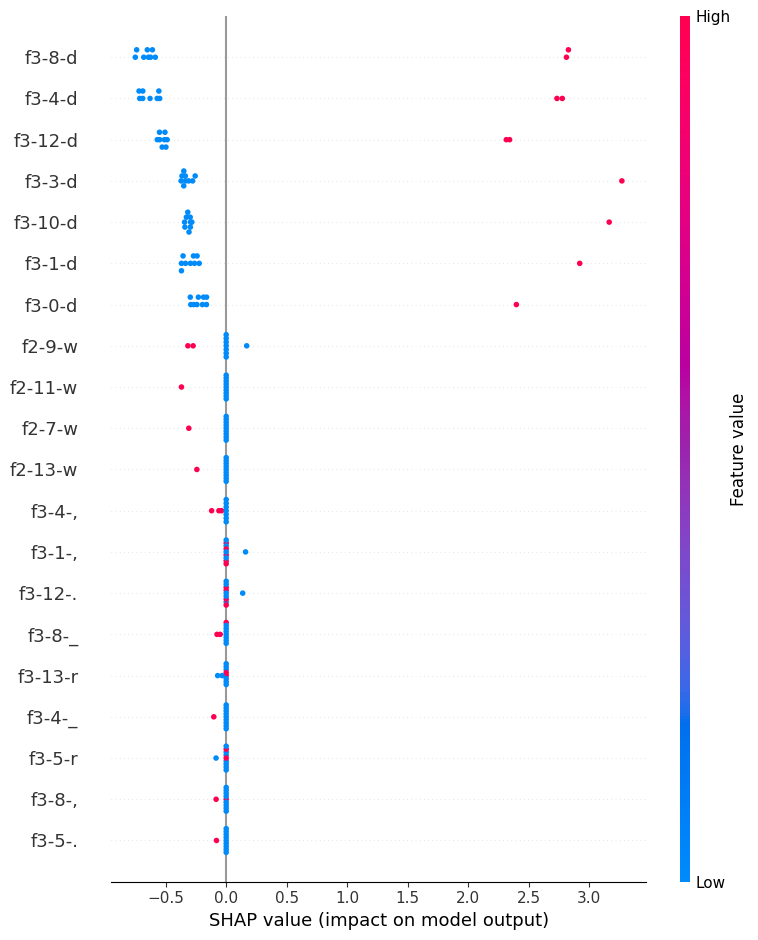


Generando explicación para clase 'R'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['_,,.,..._,._.___', ',._wu.,.,,.__.,_', '__._,,_..r.,,,.,', 'R']
  Muestra 2: [',,__.,_,_.._._,_', ',_,,._.w,___.,_,', ',,,_,,r_,...,,,_', 'R']
  Muestra 3: ['.__,_,_._,.,..,,', ',...._...uw_,__,', '._,r,_,.._,,_.,_', 'R']
  Muestra 4: ['___,___,,,_,_.,.', '_.____.._,,.,.__', '..._..r,._,.,_,.', 'R']
  Muestra 5: ['__..,_._,._._..,', ',.,_.,uw._._,...', ',r__,__,.,,.,__,', 'R']
  Muestra 6: ['._,.,.,...,_.._.', 'wu__.,,,,,_._.._', '___r_..__,.,,_,.', 'R']
  Muestra 7: ['...,_.._..__,,_.', '_._,,_..,,,_..,_', '.r,_.____,._,...', 'R']
  Muestra 8: ['.,_,._,,_...._._', ',,.,,....,,___.,', '__,_,__.,.._r_..', 'R']
  Muestra 9: ['_.,,_..,___,,_._', '.,.__w_.,_.._,,_', '...,_.._r,_,._,.', 'R']
  Muestra 10: ['_,._,..,__,.._..', ',,,.,...__.,.._,', '.,...,.r,,._,,..', 'R']


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


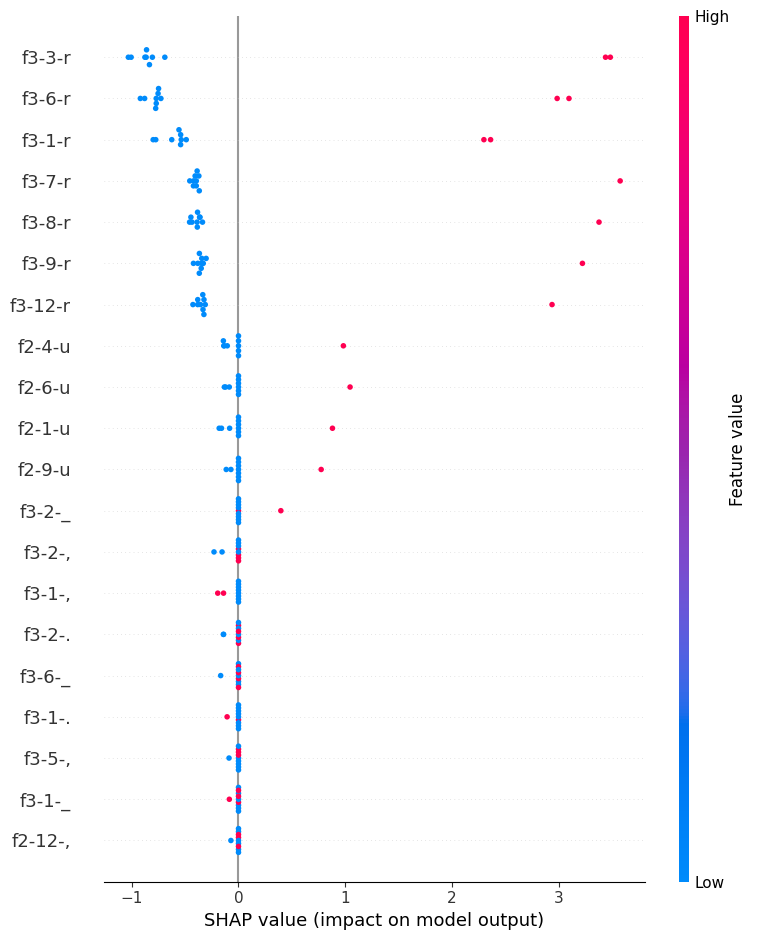


Generando explicación para clase 'V'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['_,_.,_,__,,.._,.', ',.,,.,,,wu_.,...', '.,_._,__._,__.._', 'V']
  Muestra 2: ['..,,,,.__._.,.._', 'wu,..,..,..__,,.', 'cr.,._.....,._._', 'V']
  Muestra 3: [',..,_,,..,_,__..', '..__,,,.,._.,._,', '_.,._,..cr_..._.', 'V']
  Muestra 4: [',,_,.,_,._.___,_', 'w,,,.._..._,_,,_', '._.,._.,._.__.__', 'V']
  Muestra 5: ['._..,_.__.,,.,..', '._._,.._,,_,.wu,', 'cr,_,,.___.,__..', 'V']
  Muestra 6: ['_,.._..,,.,_,_,.', '.,_.,_,wu__,.___', 'dr_,.__,_,._,,_.', 'V']
  Muestra 7: ['_,..,_,_,.,,,.,.', '_,__.._.,,.wu,._', ',...,.._.,_...,_', 'V']
  Muestra 8: ['._,._.___,,,._..', ',,____,,._,___,.', ',.._,,.,.,_,.,_.', 'V']
  Muestra 9: ['_..._,,,.,,,,,.,', '_.._.,_w,,___,_,', '_,_,,_.,..._.,,.', 'V']
  Muestra 10: ['._,.,_.,.,,.__._', '__,._,_,uw__,,.,', '_,_,._cr_,,..,..', 'V']


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


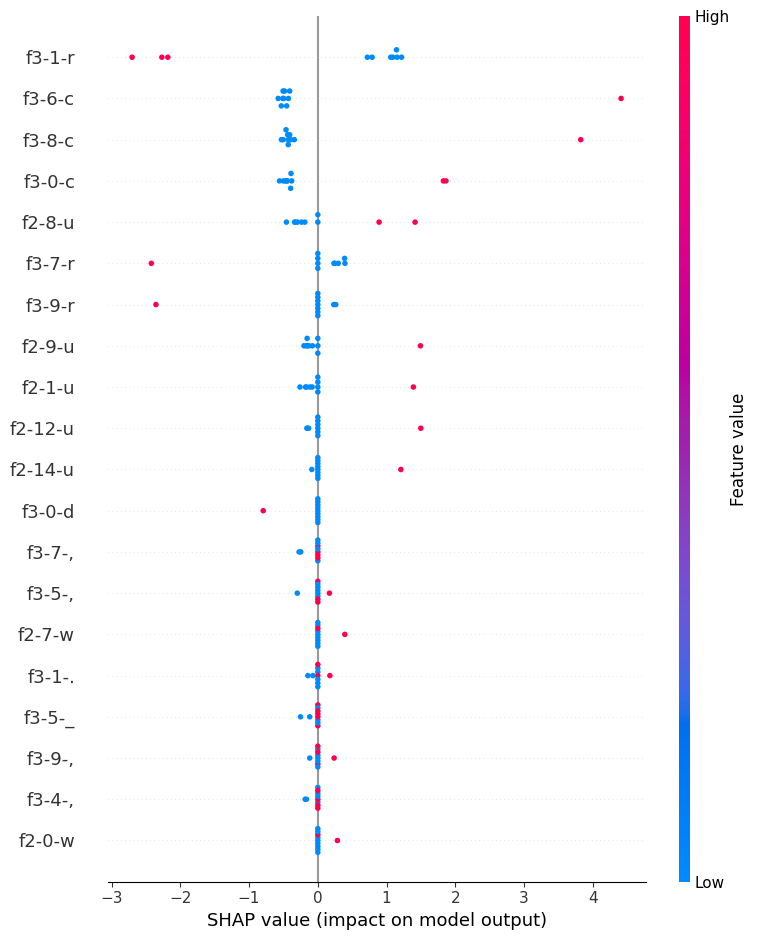

In [36]:
import shap
import numpy as np

# 💡 Nombres de clases
class_names = ["A", "D", "R", "V"]
n_samples = 10  # Número de muestras por clase

for class_idx in range(4):
    class_name = class_names[class_idx]
    print(f"\n==============================")
    print(f"Generando explicación para clase '{class_name}'")
    print(f"==============================")

    # 🟢 Buscar muestras de la clase en el conjunto de test
    indices = np.where(y_test == class_idx)[0][:n_samples]
    x_subset_cnn = x_test[indices]

    print(f" Muestras pasadas al explainer: {x_subset_cnn.shape}")
    print(f" Muestras pasadas al explainer (decodificadas):")
    for i, idx in enumerate(indices):
        print(f"  Muestra {i+1}: {test_original[idx]}")

    #  Crear el explainer con muestras solo de esa clase
    explainer_cnn = shap.KernelExplainer(predict_fn_SHAP_CNN, x_subset_cnn)

    #  Explicamos las mismas muestras del test
    shap_values_cnn = explainer_cnn.shap_values(x_subset_cnn)

    #  SHAP de la clase actual
    class_shap_values_cnn = np.array([shap_values_cnn[i][:, class_idx] for i in range(n_samples)])

    #  Mostrar resumen
    shap.summary_plot(class_shap_values_cnn, x_subset_cnn, feature_names=feature_names_mapped)


# **Filtro 4. Variable interop distance (easy)**

Obtenemos los datos

In [37]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2])
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[1], [0.25, 0.75]]) # se omitirán muestras con una distancia de 1 entre operaciones relevantes, a partir de los datos obtenidos el 25% de los datos restantes irá a validación y el 75% a prueba.

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Number of samples: 1988 train | 941 val | 3765 test
CPU times: total: 1min 4s
Wall time: 1min 5s


Cada elemento shap_values[i] tiene dimensiones (384, 4), lo que representa:

    384 características (cada una corresponde a una posición y un carácter en tu secuencia).
    4 valores por característica, que corresponden a su contribución a cada una de las 4 clases posibles.

Por lo tanto:

    shap_values[0] te da los valores SHAP para la primera muestra (dimensión (384, 4)).
    shap_values[i][j] te da los valores SHAP de la característica j en la muestra i para cada clase.


shap_values[0] tiene forma (384, 4), lo que significa:

    384 características (cada operación en las funciones codificadas).
    4 clases (tipos de errores que predice el modelo).

x_train[:10] originalmente tiene forma (10, 384):

    10 muestras.
    384 características (posiciones con operaciones codificadas).

    Se cambia a x_train[:4] para que tenga solo 4 muestras, una por cada clase.
    
Queremos visualizar cómo influyen las características en cada clase, así que se usa una muestra representativa por clase.

# **SHAPKERNEL para LSTM**

## Funcion predict

In [41]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn(x_train):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_lstm_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


In [39]:
print(label_encoder.classes_) 

['A' 'D' 'R' 'V']


In [40]:
print(data.le.classes_)

[',' '.' '_' 'c' 'd' 'r' 'u' 'w']


## Generamos la explicacion


Generando explicación para clase 'A'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: [',__.__.,_._,._._', '..,,_,__,.,u.w,.', '_.___,_d.r.._,,.', 'A']
  Muestra 2: ['.....__,...,.,_,', '_..u,w,,_.,____,', '..,,,,_d,r,_.._.', 'A']
  Muestra 3: [',_,_.,,._,,__._,', ',,,,,_u.w._..._.', ',d,r_..,,...,,,,', 'A']
  Muestra 4: [',._._,_,_.,,,.._', '...,,..u.w.__,,_', ',d.r.,,_.,._,,..', 'A']
  Muestra 5: ['.,._,,,..,._,_,.', '.,__..u.w,._,.,.', '.,._..,,_,.d.r..', 'A']
  Muestra 6: [',.,__..,.,._,.,,', ',___.,,,_.u,w_._', ',...,,,d.r,,,..,', 'A']
  Muestra 7: [',_,_,,...,_,_,,.', '_.._u.w,,__,,,_.', 'd.r,_..,_.,_,_..', 'A']
  Muestra 8: ['.__.__..,.,.._,_', ',__,..__.u,w._,.', '_,.d,r.,__,_._..', 'A']
  Muestra 9: ['.,_._,,_,,,_._,,', '__,___,u,w_,,_,,', '._._____d.r_,_,.', 'A']
  Muestra 10: ['._.,__,_..,._._,', '_,,,._.,.u,w,_,_', ',._,d,r___,,,_,_', 'A']


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
C:\Users\franm\AppData\Local\Temp\ipykernel_21452\462143712.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(class_shap_values, x_subset, feature_names=feature_names_mapped)


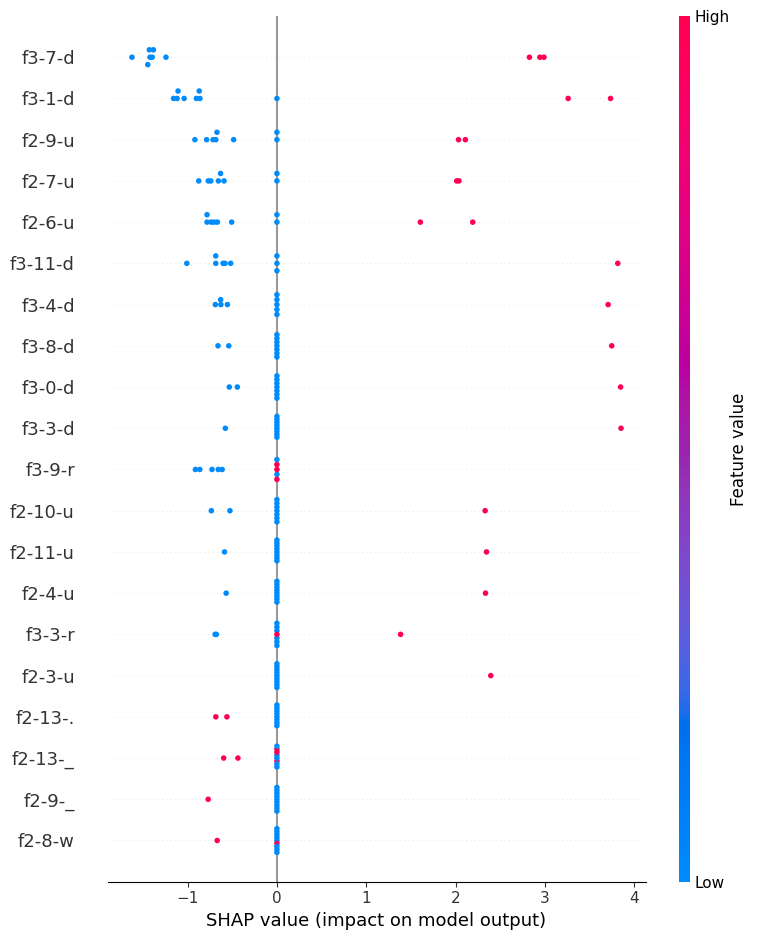


Generando explicación para clase 'D'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: [',.,___,..._,,.__', '._,__,...w,,,_,_', '.,._d,r,,__,,.._', 'D']
  Muestra 2: [',,_,.._,,,.._.,_', '_,w...___..____.', '._.,.d_r_,..,,..', 'D']
  Muestra 3: ['.._,,_,__,.,__,,', '.,.._,,.__.,._w_', ',,d_r,.__,..,.,_', 'D']
  Muestra 4: ['._.____..,___.,_', '.,.,___,.,..,,,.', '__.,.,_,,,d_r._,', 'D']
  Muestra 5: ['.,.____..,.._,_,', '.._._._..__.,,_.', 'd,r,.,_,.__._._,', 'D']
  Muestra 6: [',_,_,.._.,._.,._', '__..,...____.w_,', ',,...,____.d.r..', 'D']
  Muestra 7: [',,_...,.._,_,..,', ',,__,,__.._._,._', ',__.._d.r__.,_,_', 'D']
  Muestra 8: ['.,,_,.__,,_,_.._', ',_w.,_.,_.,,._.,', ',_,._..,___.d_r.', 'D']
  Muestra 9: ['.....,.,.,_.,,,.', '_,,.,..,_...._,.', ',._.__d,r._._._.', 'D']
  Muestra 10: ['_..,,..,,_,,,_,_', '_.____..,_,.__w,', '..,.d,r,_,.._,,.', 'D']


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


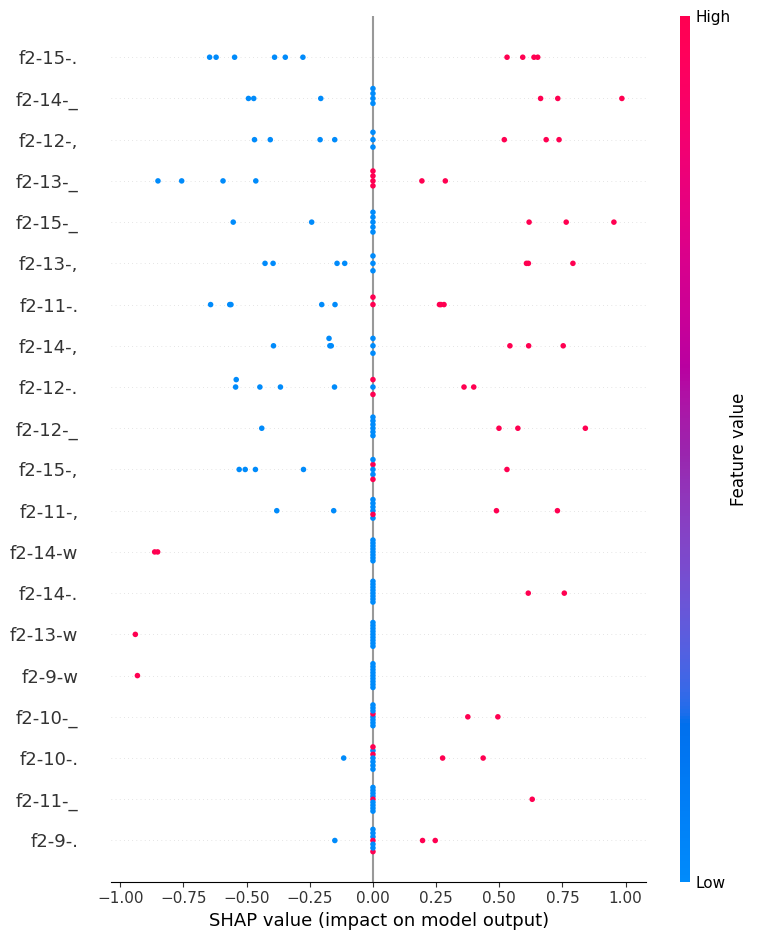


Generando explicación para clase 'R'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['..,__,.._.,_,.._', '__._..__._..__._', '__._,..__r,_.,_.', 'R']
  Muestra 2: [',.,._,.__,,__.,,', '..___._.,.u_w..,', '_..__,_,,,__r_..', 'R']
  Muestra 3: [',._,,,,.,_,.,..,', 'w.__,._._.____..', '__,,.,_,r.......', 'R']
  Muestra 4: [',_.._.,_..,_.__,', '___,,..,,___.,__', ',_,_,r.,.,__....', 'R']
  Muestra 5: [',,_._.__,_.,.,._', ',,,,.,..w_u,.,._', '.._.___.,_.,__r.', 'R']
  Muestra 6: ['__.,...__,_,.___', '_,.__,,,,u,w,__.', '_,__.r._._.___,_', 'R']
  Muestra 7: ['_._..,_.,.._._..', '..,,.u,w_,.,,.__', '.,.__,,r...,.,_.', 'R']
  Muestra 8: ['.,,.,,.....,._..', ',,w.u__.,.,__.,.', ',,_.._,r.___,_,,', 'R']
  Muestra 9: ['.._.____,_._,_.,', 'u_w._,,,____,_..', '_r____.,.,,.,.,_', 'R']
  Muestra 10: [',._.,...,.._,,.,', '._.,,.__,._,_._,', ',..r__..._,,..__', 'R']


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


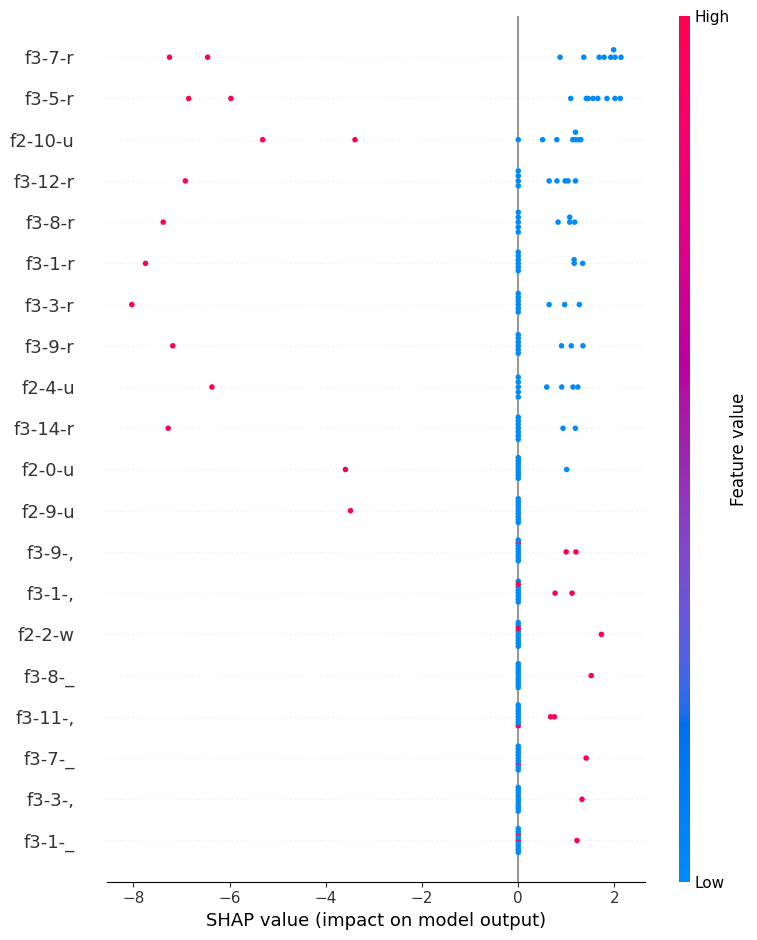


Generando explicación para clase 'V'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['__.,,,.,__,,..,,', 'w,u._,,_.,,.._._', '_.c_r,..__,_,.,,', 'V']
  Muestra 2: ['__._,_,.._..,.,_', '__..w_u,.,_.,._.', '..,d,r__..._..__', 'V']
  Muestra 3: ['.,,._,_,,.,,,_._', '..,_._,,._.,,_..', ',,____,.c.r___,,', 'V']
  Muestra 4: [',__,._,.___._.__', ',,.,__,._,,,_._,', ',.,c_r.,,,,_,__,', 'V']
  Muestra 5: ['.....__,.....__.', '__.w.._,._,._,,.', '..__c,r_,_,_..,.', 'V']
  Muestra 6: ['._,.,_,._.._,,_.', ',_.,..,__u_w_..,', '.,_.,_,,_____.,.', 'V']
  Muestra 7: ['__..,,______._.,', ',,.,._w,,_.,.,._', '__,_,.,_.,....,_', 'V']
  Muestra 8: [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', 'V']
  Muestra 9: [',..,__,,_._,.,,.', 'u_w...___,_.____', ',__,_.,,,_._.,_.', 'V']
  Muestra 10: ['__,,__.,._._,_,_', '_.,.,_,,_.w.__,.', '..,_,..__,__._,_', 'V']


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


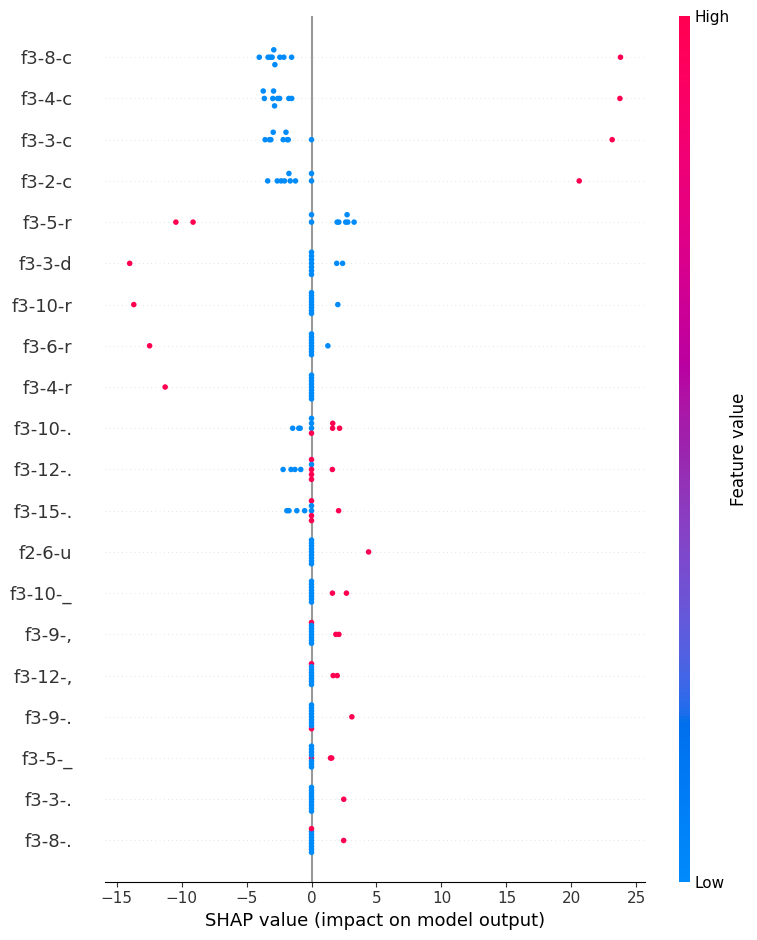

In [42]:
import shap
import numpy as np

# 💡 Nombres de clases
class_names = ["A", "D", "R", "V"]
n_samples = 10  # Número de muestras por clase

for class_idx in range(4):
    class_name = class_names[class_idx]
    print(f"\n==============================")
    print(f"Generando explicación para clase '{class_name}'")
    print(f"==============================")

    # 🟢 Buscar muestras de la clase en el conjunto de test
    indices = np.where(y_test == class_idx)[0][:n_samples]
    x_subset = x_test[indices]

    print(f" Muestras pasadas al explainer: {x_subset.shape}")
    print(f" Muestras pasadas al explainer (decodificadas):")
    for i, idx in enumerate(indices):
        print(f"  Muestra {i+1}: {test_original[idx]}")

    #  Crear el explainer con muestras solo de esa clase
    explainer = shap.KernelExplainer(predict_fn, x_subset)

    #  Explicamos las mismas muestras del test
    shap_values = explainer.shap_values(x_subset)

    #  SHAP de la clase actual
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(n_samples)])

    #  Mostrar resumen
    shap.summary_plot(class_shap_values, x_subset, feature_names=feature_names_mapped)


In [ ]:
import matplotlib.pyplot as plt

# Mostrar la contribución de una característica específica para las primeras 10 muestras
shap_values_for_feature = [shap_values[i][feature_index] for i in range(10)]

plt.bar(range(10), shap_values_for_feature)
plt.title(f'Contribución de {feature_to_check} para las primeras 10 muestras')
plt.xlabel('Muestra')
plt.ylabel('Contribución SHAP')
plt.show()


NameError: name 'feature_index' is not defined

ANÁLISIS GRAFICO CLASE A (VIOLACION DE ATOMICIDAD  ‘u’‘w’ ‘d’‘r’)

Como podemos observar las características más influyentes son lsa que se encuentran en la parte superior del gráfico:

317 f3-7-r
349 f3-11-r
365 f3-13-r
291 f3-4-c

El aumento de la operación r (read) influye positivamente en predecir la clase A, sin embargo, el aumento de la operación c (verificación de si se ha escrito) reduce la predicción de la clase A.
Desde las carácteriasticas 276 hasta 230 tenemos las operaciones de  'd' 'r' 'u'  cuyo aumento influye en predecir la clase A.
Las características finales se refieren a no-ops y una 'u' ¿? , y como vemos sus valores shap se situan en el centro de la gráfica, es decir, dichas operaciones tienen un impacto muy bajo en la prediccion del modelo para la clase A.
No favorecen ni reducen la probabilidad de su predicción. El modelo no está utilizando las no-ops de manera significativa para tomar la decisión de predicción de la clase A.

Teniendo en cuenta que la mayoria son operaciones no-ops, cuadra ya que estas no aportan nada útil en la predicción.

317 f3-7-r
349 f3-11-r
365 f3-13-r
291 f3-4-c
276 f3-2-d
269 f3-1-r
364 f3-13-d
357 f3-12-r
341 f3-10-r
373 f3-14-r
301 f3-5-r
166 f2-4-u
230 f2-12-u
336 f3-10-,
328 f3-9-,
314 f3-7-_
158 f2-3-u
305 f3-6-.
320 f3-8-,
345 f3-11-.

------------------------------------------------------------------------------------------------------------------------------------------------------

ANÁLISIS GRAFICO CLASE D (DEADLOCK no-op  ‘d’‘r’ / 'w'  ‘d’‘r’)

Como vemos en el grafico, las características mas influyentes son 116 y 230 correspondientes a la operación 'u'. Además tienen valores shap negativos, indicando que la operqación u tiene un impacto muy bajo en la predicción de la clase D. Influencia alta pero negativa. Esto cuadra pues no es una operación significativa para este tipo de error. 

Las siguiente caracteristica más influyente es 317 'r'. Con un impacto positivo en la prediccion de dicha clase.
Seguimos con la caracteristica 158 'u', pero esta vez con valores shap cercanos a 0 (tirando a +). ¿ns q decir?

Destacan las caracteristicas 291 'c' y 276 'd' con un impacti alto y negtaivo en la predicción de la clase D. La operación 'c'  me cuadra ya que no es una operacion significativa en el tipo de error y por lo tanto la presencia en la muestra ocasiona la  alta probabilidad en la no prediccion de este error D. Resoecto a la operacion d ns muy bien que decir, se me ocurre que quizás como es una operacion que aparece en los 2 errores de Deadlock y Atomicidad, el modelo pueda tener dudas con esta... ns

Las caract. restantes correspoinden a no-ops y 'r' y 'w' estas ñultimas con valores shap más altos. Indicando que dichas ops tiene una influencia alta en la prediccion de esta clase D.

166 f2-4-u
230 f2-12-u
317 f3-7-r
158 f2-3-u
291 f3-4-c
365 f3-13-r
349 f3-11-r
269 f3-1-r
357 f3-12-r
242 f2-14-_
216 f2-11-,
225 f2-12-.
276 f3-2-d
248 f2-15-,
202 f2-9-_
232 f2-13-,
191 f2-7-w
250 f2-15-_
226 f2-12-_
249 f2-15-.

------------------------------------------------------------------------------------------------------------------------------------------------------
RARILLO
ANÁLISIS GRAFICO CLASE R (CONDICIÓN DE CARRERA no-op /'w' / 'u''w' /'w''u'/ + 'r') no hacer 'c''r' para comprobar si se ha escrito y se puede leer correctamente sin carrera

Vamos a comenzar observando las últimas caracteristicas que corresponden a 336, 314, 328, 346 correspondientes a no-ops. Como vemos tienen valor4es shap cercanos a 0 lo que indica que su presencia no tiene mucha influencia pero so valores posotivos por lo que  juegan un papel clave en la predicción de R, lo que es coherente con las regla de clasificación

 ¿?¿?¿Vamos ahora a analizar la caraterística 291 'c', la única con valores altos shap postivos. Es decir , en teoría esta operación tiene una influencia positiva sbre el modelo oara predecir el eror R. El explainer captura tanto la presencia como la ausencia de una operación en las secuencias. Sabemos que todas las secuencias que contienen una c estan clasificadas como V (Comprobado abajo). Por lo tanto lo que está ocuuriendo es que la ausencia de esta operación en las muestras es una gran inlfuencia positiva para que el modelo las prediga como R.  

Si observamos las 2 caracterisitcas con más influencia, situadas arriba del gráfico, corresponden a la op 'd'. Además con valores shap negatuvos, es decir que tienen gran influencia sobre el modelo para no predecir la clase  R. Me cuadra porque esta operación no influye en este tipo de error. Por lo tanto su presencia no debería hacer que el modelo prediga el error R, lo contrario, que es justo lo que ocurre.

Por último, desde las caract. 317 - 230 tenemos valor4es shao negativos. Corresponden a las ops 'r' 'u' 'd' '.' (con orden de aparencia). ¿¿ns muy bien que decir?
 
 
¿La op r que aparece en todas las combinaciones que provocan este error no debería tener valores shap positivos? podría indicar que su contribución a la prediccion de la clase, depende de su contexto en la secuencia??? El uso correcto de las oepraciones para evitar la condición de carrera incliye el uso de r...¿relevante?

ME llama la atención que la operación w que aparece en todas las combinaciones, no sea una operacion influyente a la h de predecir esta clase por el modelo. QUe 'w' y 'u' no aparezacan como op clave,puede ser porque la combinación específica de operaciones es más importante que la presencia en sí.

276 f3-2-d
364 f3-13-d
317 f3-7-r
365 f3-13-r
349 f3-11-r
369 f3-14-.
373 f3-14-r
357 f3-12-r
291 f3-4-c
301 f3-5-r
340 f3-10-d
341 f3-10-r
166 f2-4-u
230 f2-12-u
268 f3-1-d
336 f3-10-,
158 f2-3-u
314 f3-7-_
328 f3-9-,
346 f3-11-_


--------------------------------------------------------------------------------------------------------------------------------------------------------------------

ANÁLISIS GRAFICO CLASE V (No error. Cuando f3 contiene todo no-ops o la secuencia 'c''r'   y cuando 'w''u' 'd''r')

Destaca la caract. 291 corresponiente a la op 'c' la única con valores altos de shap, indicando que la presencia de esta op oinfluye positivamente en la prediccion de esta clase V. Cuadra porque es una op que aparece bastante en las combinaciones de op que causan esta clase.

Que las caracteristicas situadas en la parte de arriba del gráfico que corresponden a la op 'r', tengan valores shap negativos puede deberse a que hay muchas muestras en donde ésta op. esté sola o no tenga una 'c' delante. Y si no se cumple la secuencia 'c''r', el modelo no debería predecir V.  


Las operaciones 'w' y 'u' no aparecen en el gráfico y esto puede deberse a que la frecuencia de éstas en los datos etiquetados como V y las demás clases están distribuidas de manera similar. Esto puede hacer que el modelo las ignore. 

317 f3-7-r
291 f3-4-c
349 f3-11-r
365 f3-13-r
269 f3-1-r
357 f3-12-r
341 f3-10-r
301 f3-5-r
364 f3-13-d
373 f3-14-r
336 f3-10-,
328 f3-9-,
320 f3-8-,
314 f3-7-_
345 f3-11-.
377 f3-15-.
276 f3-2-d
360 f3-13-,
305 f3-6-.
297 f3-5-.

In [44]:
def filter_samples_with_c(train_original, target_char='c'):
    """
    Filtra las muestras que contienen la operación 'c' independientemente de la clase.
    """
    filtered_samples_with_c = []
    
    # Iterar sobre las muestras de 'train_original' (cada elemento es una lista de 4 elementos)
    for sample in train_original:
        sequences = sample[:-1]  # Las tres primeras columnas son las secuencias de operaciones
        label = sample[-1]  # La última columna es la etiqueta
        
        # Verificar si 'c' está en alguna de las secuencias
        if any(target_char in seq for seq in sequences):
            filtered_samples_with_c.append((sequences, label))
    
    return filtered_samples_with_c

# Llamar a la función para filtrar las muestras que contienen 'c'
filtered_samples_with_c = filter_samples_with_c(train_original)

# Imprimir las muestras filtradas
print("Muestras que contienen la operación 'c':")
if filtered_samples_with_c:
    for seq, label in filtered_samples_with_c:
        print(f"Secuencias: {seq}, Etiqueta: {label}")
else:
    print("No se encontraron muestras que contengan 'c'.")


Muestras que contienen la operación 'c':
Secuencias: ['.._,,_,,_,,___,.', ',w._u,_,_..._,._', '_,_,._.c,_r..._,'], Etiqueta: V
Secuencias: ['.,,__,,_,,__,.._', '_.,__,__.,,,_,_.', '._.._,.,_,_.cr..'], Etiqueta: V
Secuencias: ['...__.,..__._.._', '.....,_.,_,w_._,', ',..._.,_,,.cr,_,'], Etiqueta: V
Secuencias: ['.__,_,,.._.,._.,', '_.___._..,_.w._u', '...,.,,..c_.r,._'], Etiqueta: V
Secuencias: ['...,,,__.__.___,', '.,_,_u_,w..,_.,.', '_.c,_r_,.,,,,__,'], Etiqueta: V
Secuencias: [',,,,__,.,_,____,', ',,wu..._..,.__._', ',_,.,_.,.,cr____'], Etiqueta: V
Secuencias: ['__.,__,..__,._,.', '_,,._,._.w,.,_,.', '.,,_,.cr,.___.,_'], Etiqueta: V
Secuencias: ['.....,._._,,.,__', '.,.,wu.__._._.,.', '.cr,,__...,__..,'], Etiqueta: V
Secuencias: ['.___._.___._,,.,', ',,_._,w,,__...,.', '_._.,,_,cr__,.,.'], Etiqueta: V
Secuencias: ['.,,..,,__...__._', '_____u__w,,,..__', 'c_,r_,._._.,,,.,'], Etiqueta: V
Secuencias: [',..,,.__,.__..__', '.,____,w.,u_,__,', ',.__.c_.r,,.,__,'], Etiqueta: V
Secuencias: [

In [45]:
def filter_samples_by_label(train_original, target_label='R'):
    """
    Filtra las muestras que tienen la etiqueta especificada (en este caso, 'R').
    """
    filtered_samples_r = []
    
    # Iterar sobre las muestras de 'train_original' (cada elemento es una lista de 4 elementos)
    for sample in train_original:
        sequences = sample[:-1]  # Las tres primeras columnas son las secuencias de operaciones
        label = sample[-1]  # La última columna es la etiqueta
        
        # Verificar si la etiqueta es la que estamos buscando (en este caso 'R')
        if label == target_label:
            filtered_samples_r.append((sequences, label))
    
    return filtered_samples_r

# Llamar a la función para filtrar las muestras con etiqueta 'R'
filtered_samples_r = filter_samples_by_label(train_original)

# Imprimir las muestras filtradas
print("Muestras clasificadas como 'R':")
if filtered_samples_r:
    for seq, label in filtered_samples_r:
        print(f"Secuencias: {seq}, Etiqueta: {label}")
else:
    print("No se encontraron muestras clasificadas como 'R'.")


Muestras clasificadas como 'R':
Secuencias: ['____._,.,_.,_,_,', '_._...wu,,.,.,,_', ',,,r.._,_...__._'], Etiqueta: R
Secuencias: ['..._,__,.,,.,.__', '.,..__,__.,,_.,_', '._.r...__,,.___.'], Etiqueta: R
Secuencias: [',.._.__,_,_.,.,.', '__..,,.,.,.,._,,', ',r,...,_,,,,,...'], Etiqueta: R
Secuencias: ['_,,_.____,,_.,.,', '_uw,__,,.,,,.,,,', '_._..r._..,_,__,'], Etiqueta: R
Secuencias: ['.,..._,__.,..,,,', ',....,.,_._.,_,,', '_,__._._,,_r,.._'], Etiqueta: R
Secuencias: [',__.,_.,_.___,._', ',_._.._,,__,,,,,', '___.._._.._r__,_'], Etiqueta: R
Secuencias: [',.._,__..,..,.,.', '.,,,_,_,._...,,_', ',,___.___,,r,,..'], Etiqueta: R
Secuencias: [',_,_.,.,,,.___,,', ',,,_w,,u,_,__,.,', '__r_.,,_._____.,'], Etiqueta: R
Secuencias: [',___,_..._.,_...', '._,__..__..__.,_', '_...._,.,.._r_..'], Etiqueta: R
Secuencias: ['._,.,._,...._.__', '..,,_.,__w,,,,,,', ',_.r__.__,,,_,,,'], Etiqueta: R
Secuencias: [',_,_,_.,,.___,_.', '.__.._w,,,,.,,._', 'r,_,.,_._,.,_,__'], Etiqueta: R
Secuencias: [',,_,,,.,

Generando gráfico para la clase  A


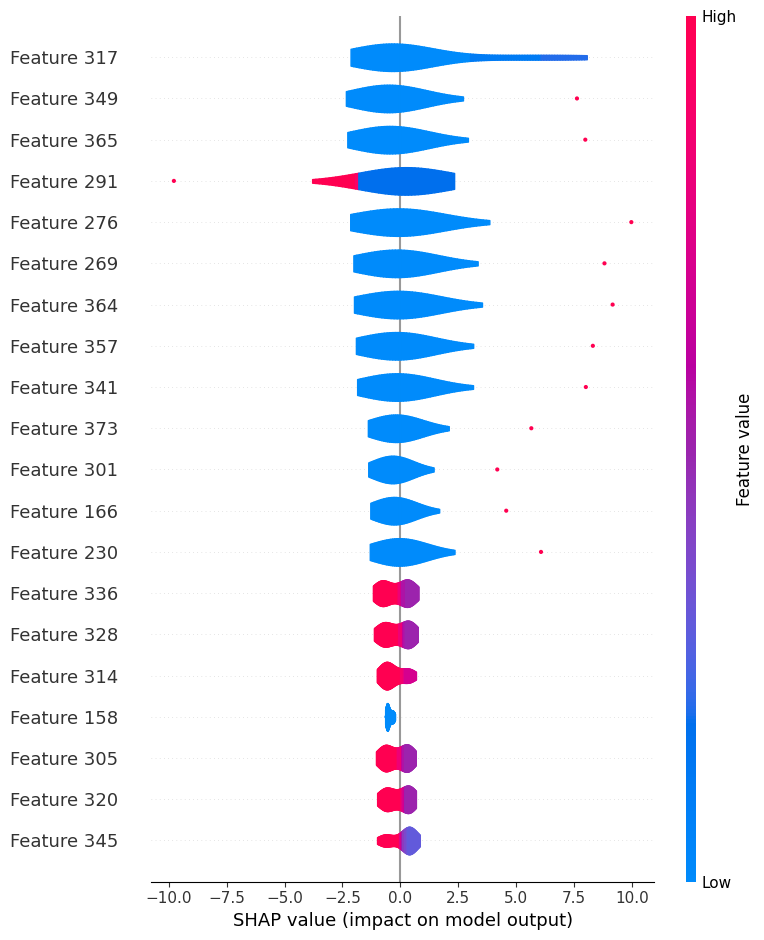

Generando gráfico para la clase  D


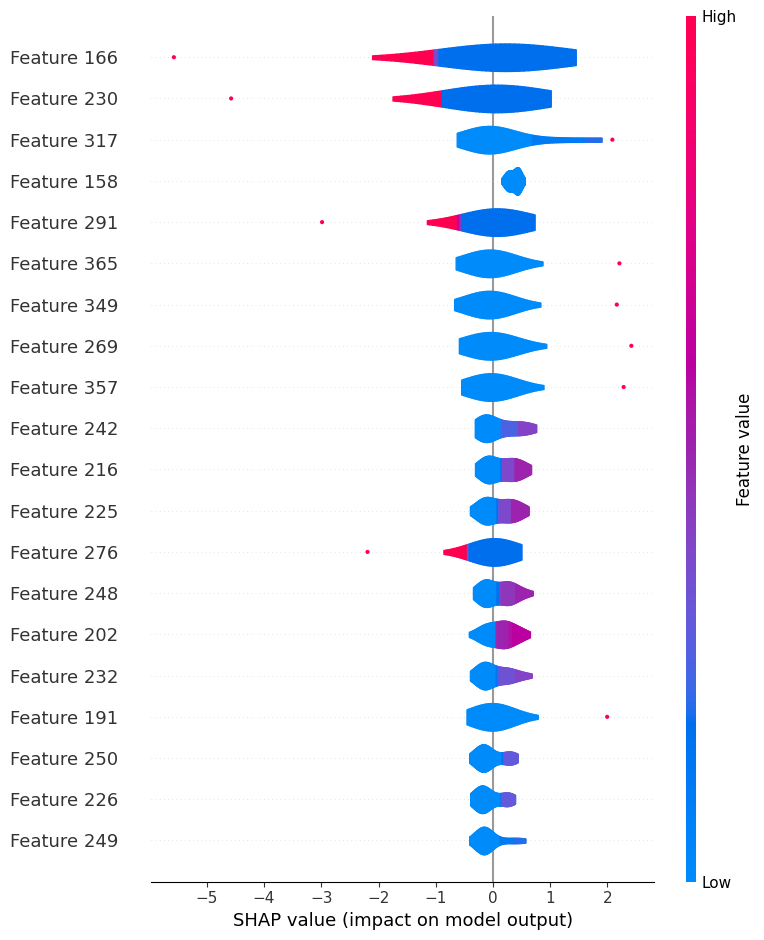

Generando gráfico para la clase  R


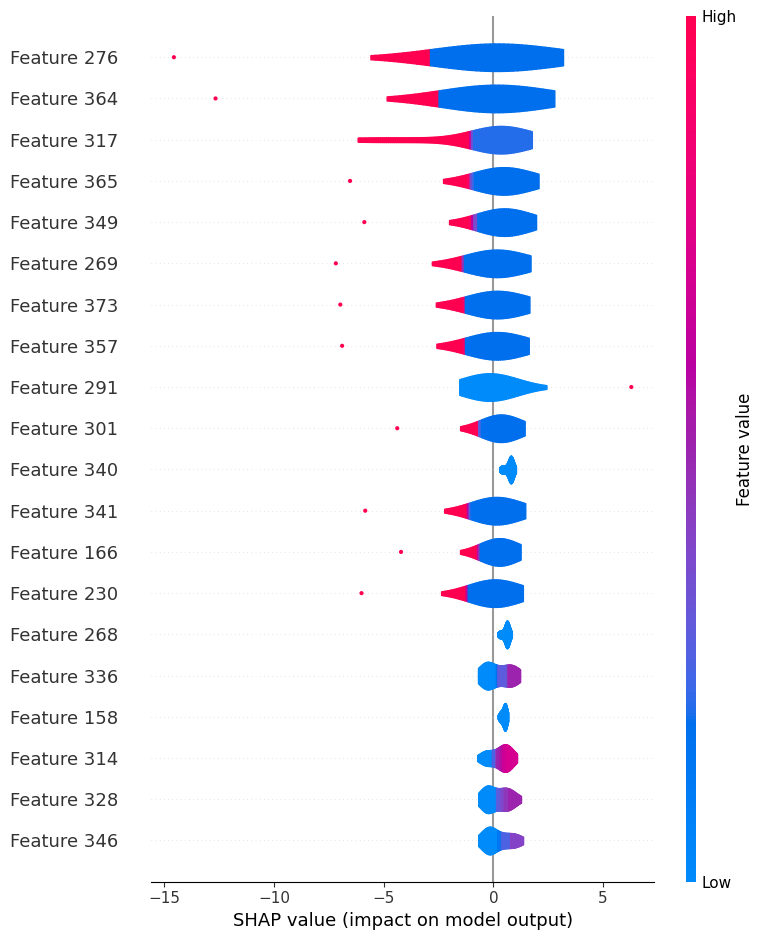

Generando gráfico para la clase  V


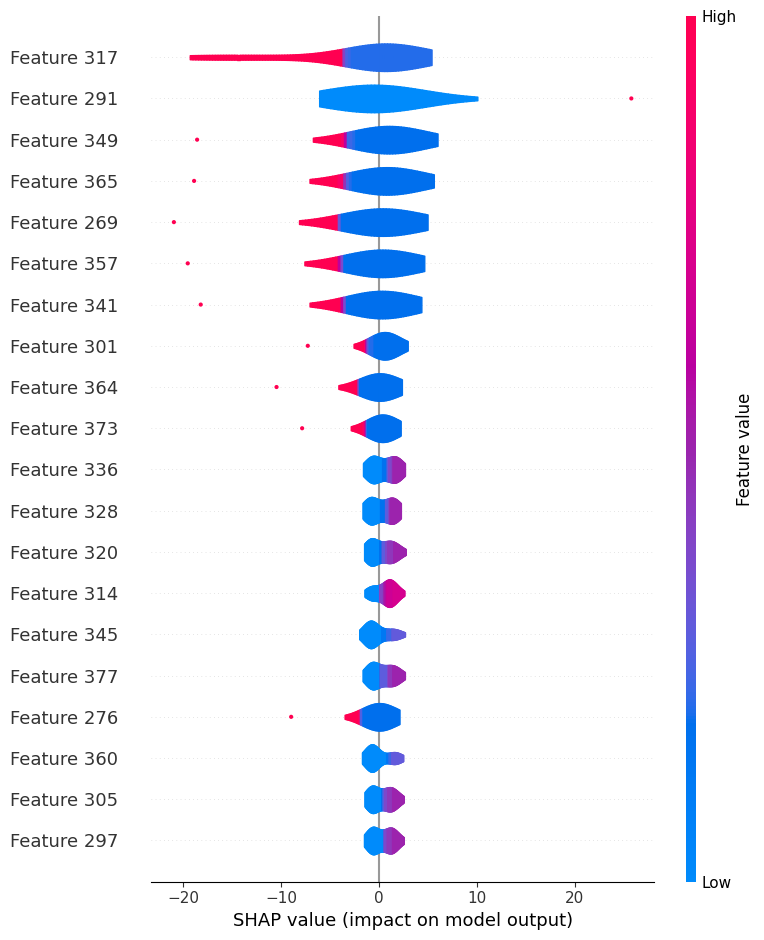

In [51]:
# Para las primeras 10 muestras
for class_idx in range(4):  # Asumiendo que hay 4 clases
    # Extraer la contribución de todas las características para esta clase en las primeras 10 muestras
    print("Generando gráfico para la clase ", label_encoder.classes_[class_idx])
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(10)])  # Obtener los valores SHAP para cada una de las 10 muestras y la clase 'class_idx'


    # Obtener los valores SHAP para cada una de las 10 muestras y la clase 'class_idx'
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(10)])

    # Asegurarse de que 'shap_values' y 'x_train' tengan el formato adecuado
    shap_values_reshaped = np.array(class_shap_values, dtype=np.float64)
    x_train_reshaped = np.array(x_train[:10], dtype=np.float64)  # Asegúrate de que x_train tenga el tamaño correcto


    # Visualizar los valores SHAP para esta clase en las primeras 10 muestras con gráfico de tipo "violin"
    shap.summary_plot(shap_values_reshaped, x_train_reshaped, plot_type="violin")


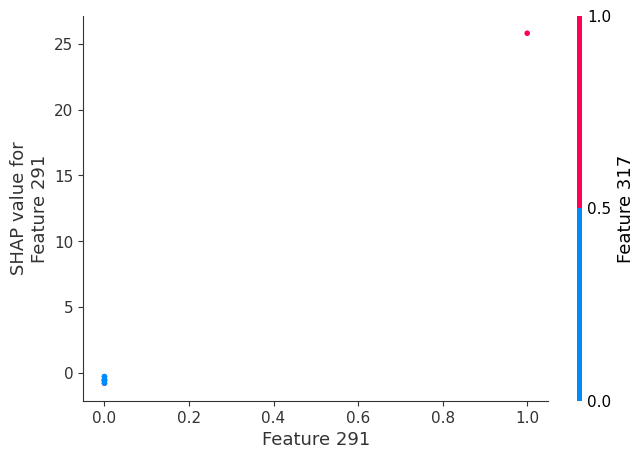

In [ ]:
shap.initjs()
shap.dependence_plot("Feature 317", shap_values_reshaped, x_train_reshaped, interaction_index="Feature 291")

Generando gráfico para la clase  A


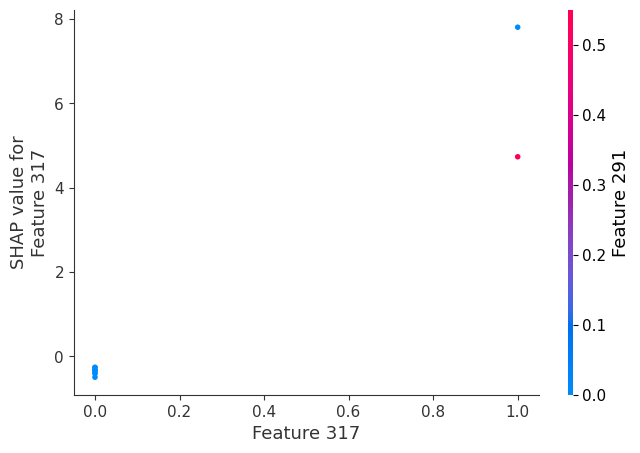

Generando gráfico para la clase  D


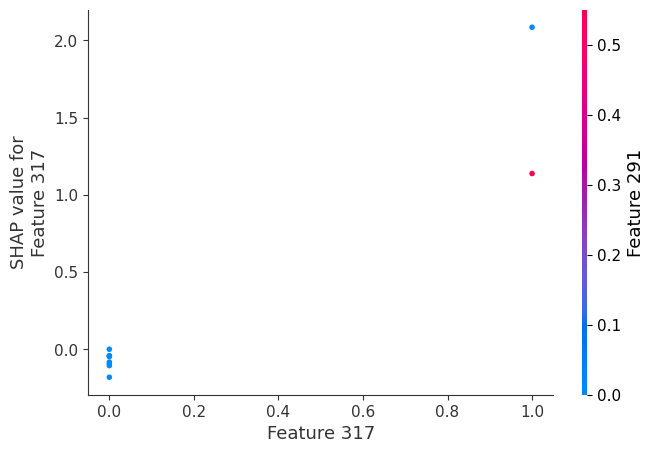

Generando gráfico para la clase  R


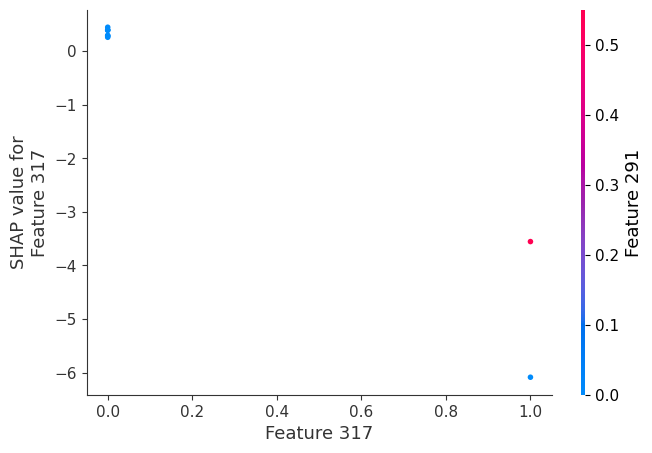

Generando gráfico para la clase  V


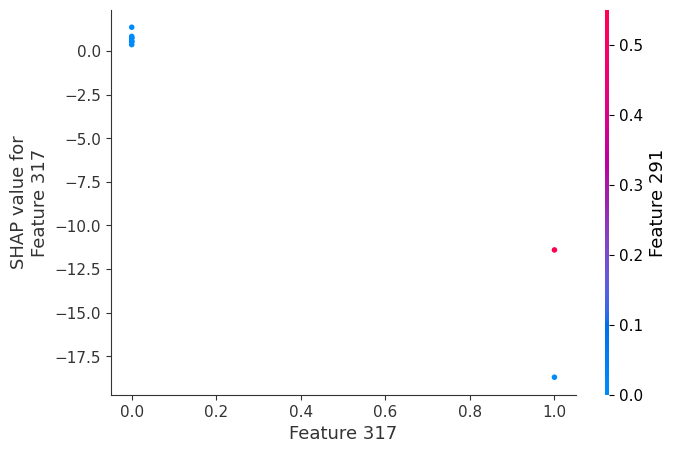

In [25]:

# Para las primeras 10 muestras
for class_idx in range(4):  # Suponiendo que hay 4 clases
    print("Generando gráfico para la clase ", label_encoder.classes_[class_idx])
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(10)])  # Obtener los valores SHAP para cada una de las 10 muestras y la clase 'class_idx'

    # Reshape para asegurar que las formas sean correctas
    shap_values_reshaped = np.array(class_shap_values, dtype=np.float64)
    x_train_reshaped = np.array(x_train[:10], dtype=np.float64)  # Asegúrate de que x_train tenga el tamaño correcto

    # Aquí se genera el gráfico de dependencia entre las características '291' y 'c'
    shap.dependence_plot("Feature 317", shap_values_reshaped, x_train_reshaped, interaction_index="Feature 291")
    # Mostrar el gráfico
    plt.show()


Generando gráfico para la clase  A


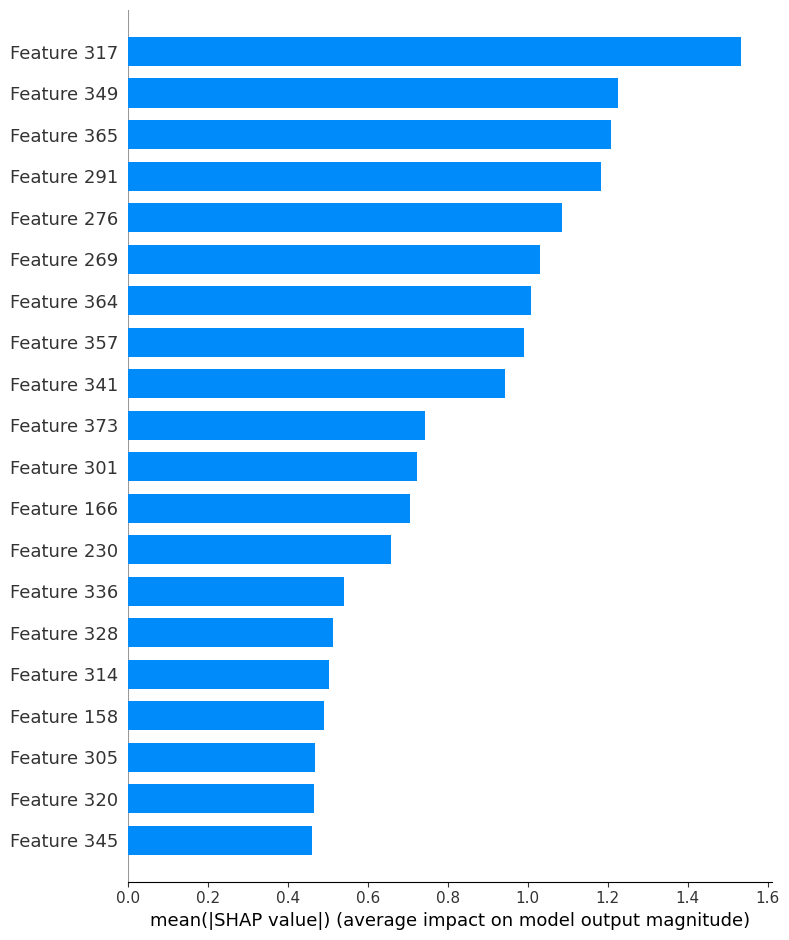

Generando gráfico para la clase  D


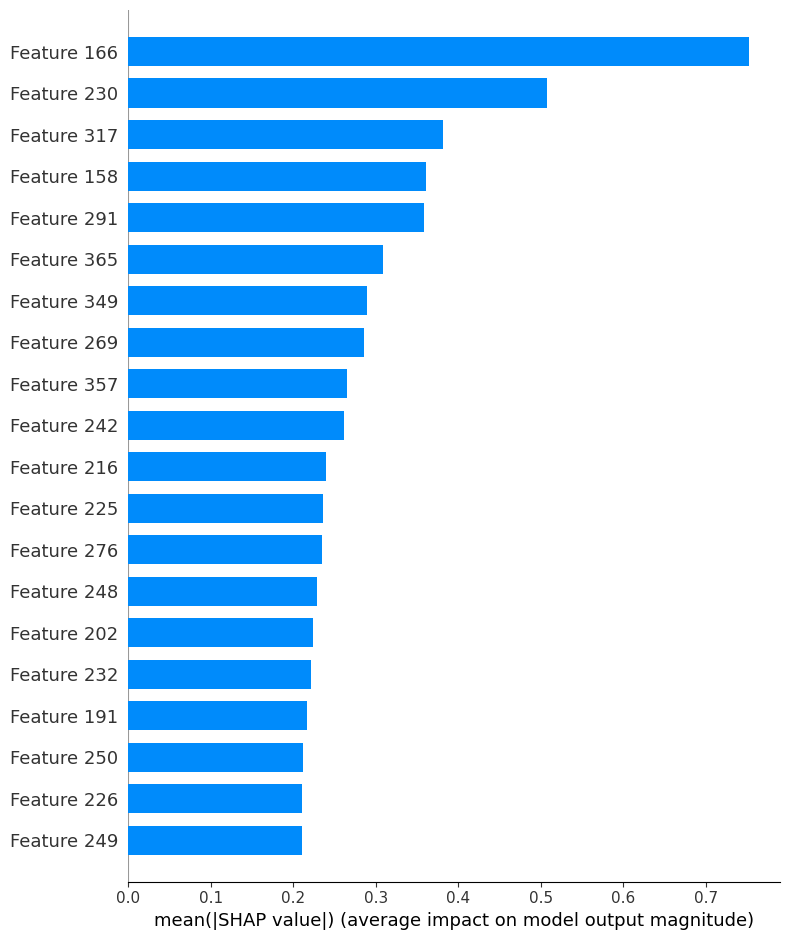

Generando gráfico para la clase  R


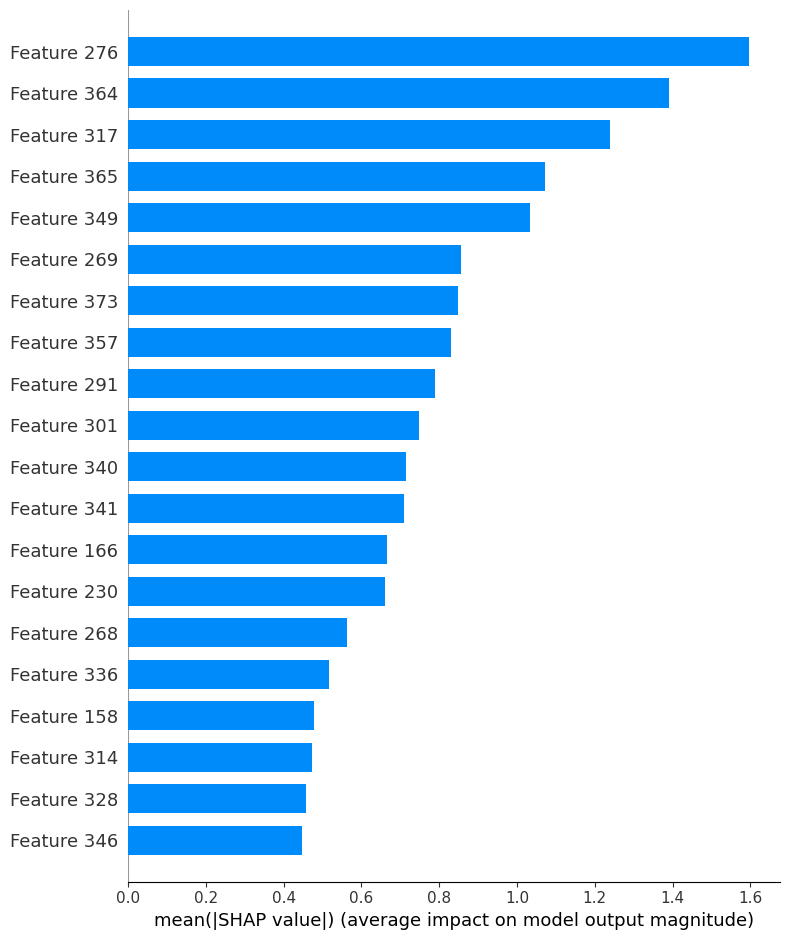

Generando gráfico para la clase  V


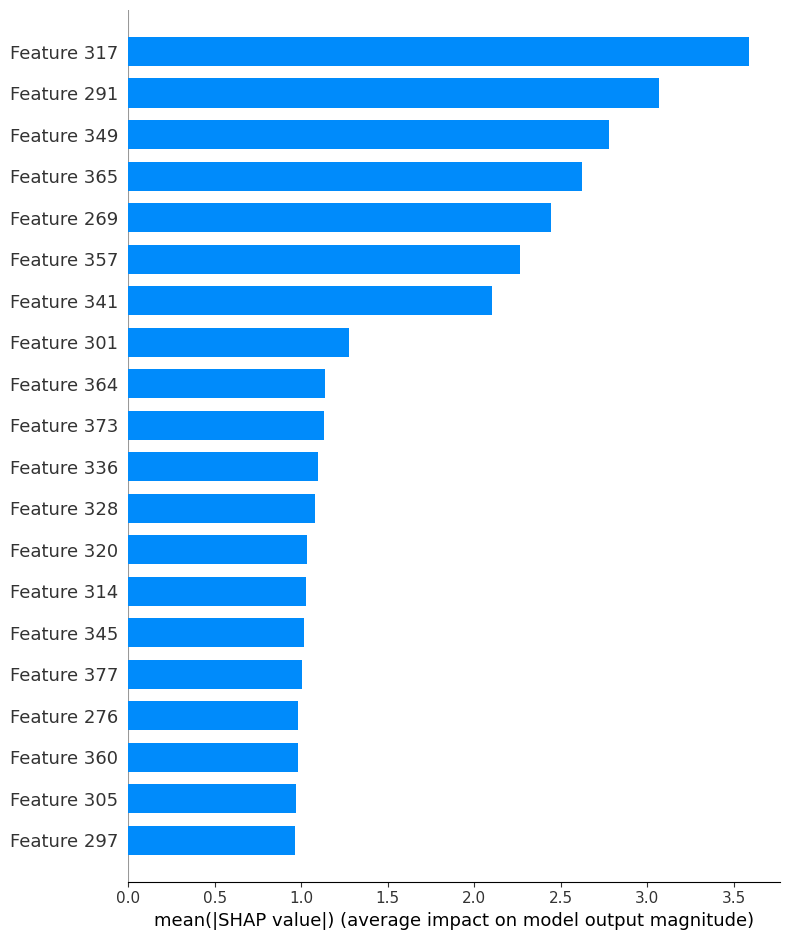

In [18]:
# Para las primeras 10 muestras
for class_idx in range(4):  # Asumiendo que hay 4 clases
    # Extraer la contribución de todas las características para esta clase en las primeras 10 muestras
    print("Generando gráfico para la clase ", label_encoder.classes_[class_idx])
    
    # Obtener los valores SHAP para cada una de las 10 muestras y la clase 'class_idx'
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(10)])

    # Asegurarse de que 'shap_values' y 'x_train' tengan el formato adecuado
    shap_values_reshaped = np.array(class_shap_values, dtype=np.float64)
    x_train_reshaped = np.array(x_train[:10], dtype=np.float64)  # Asegúrate de que x_train tenga el tamaño correcto

    # Visualizar los valores SHAP para esta clase en las primeras 10 muestras con gráfico de tipo "bar"
    shap.summary_plot(shap_values_reshaped, x_train_reshaped, plot_type="bar")


 Como observamos en el análisis anterior. La característica 291 f3-4-c es la única con valores altos shap postivos para la clase de Condición de carrera. Esta operación tiene una influencia positiva sbre el modelo para predecir el error R. 
 El explainer captura tanto la presencia como la ausencia de una operación en las secuencias. 
 Sabemos que todas las secuencias que contienen una c estan clasificadas como V (Comprobado arriba). Por lo tanto, lo que está ocuuriendo es que la ausencia de esta operación en las muestras es una gran inlfuencia positiva para que el modelo las prediga como R.
Para comprobar que esto ocurre así, vamos a aplicar el explainer a una sola muestra en vez de a un conjunto. Así  podremos observar que esta característica tiene una alta contribución aunque su operación no esté en la muestra. 
Así demostraríamos que la ausencia de las operaciónes en las muestras es un factor igual de importante que la presencia. 

    La contribución de las características a una muestra en el contexto de SHAP representa cuánto influye cada característica en la predicción del modelo para esa muestra en particular.Nos dice cuánto cambia la predicción del modelo debido a la presencia o valor de una característica específica en una muestra determinada

Teniendo en cuenta esto, vamos a aplicar el explainer a una sola muestra, pero sólo a la muestra en la que más contribución ha tenido la característica 291 f3-4-c.
Para saber esto, vamos a sacar la contribución de la característica a cada muestra. Como observamos abajo tenemmos dicha contribucion a cada una de las clases que tenemos.
Podemos comprobar que la muestra 4 es la que tiene los mayores valores absolutos, por lo que usaremos esta muestra.

Muestra 4:

In [100]:
# Característica a buscar
feature_to_check = 'f3-4-c'

# Obtener el índice de la característica en la lista de nombres de características
feature_index = 291

# Iterar sobre las primeras 10 muestras
for i in range(10):
    # Obtener los valores SHAP para todas las clases en la muestra i
    class_shap_values = shap_values[i]  # Esto devuelve los valores SHAP para cada clase
    
    # Verificar si el valor para la característica es distinto de 0
    contribution = class_shap_values[feature_index]  # Accedemos al valor en la posición correcta

   # Si el valor es un array (podría ser un valor de SHAP por clase)
    if isinstance(contribution, np.ndarray):
        if np.any(contribution != 0):  # Verificamos si hay algún valor distinto de cero en el array
            print(f"La característica '{feature_to_check}' aparece en la muestra {i} con contribución significativa {contribution}")

La característica 'f3-4-c' aparece en la muestra 0 con contribución significativa [ 0.19750159  0.09072739 -0.07743832 -0.61348669]
La característica 'f3-4-c' aparece en la muestra 1 con contribución significativa [ 0.2178268   0.01451486 -0.24732317 -0.28574974]
La característica 'f3-4-c' aparece en la muestra 2 con contribución significativa [ 0.20971563  0.08388844 -0.14450569 -0.58563408]
La característica 'f3-4-c' aparece en la muestra 3 con contribución significativa [ 0.17019044  0.         -0.21463435 -0.2692512 ]
La característica 'f3-4-c' aparece en la muestra 4 con contribución significativa [-9.78354762 -2.98648658  6.28995391 25.79686119]
La característica 'f3-4-c' aparece en la muestra 5 con contribución significativa [ 0.30180793  0.10801097 -0.1866997  -0.77017751]
La característica 'f3-4-c' aparece en la muestra 6 con contribución significativa [ 0.21506329  0.0767609  -0.1790063  -0.54225606]
La característica 'f3-4-c' aparece en la muestra 7 con contribución signific

In [103]:
train_original[4]

[',___._.,..___,,,', '.._,_____..w,.u_', '.._.._.._._,,.,,', 'V']

In [97]:
# Obtener los valores SHAP para una sola muestra
single_sample = x_train[4]  # Tomar la primera muestra de x_train
shap_values_single = explainer.shap_values(single_sample)  # Calcular valores SHAP para esta única muestra



Generando gráfico para la clase  A


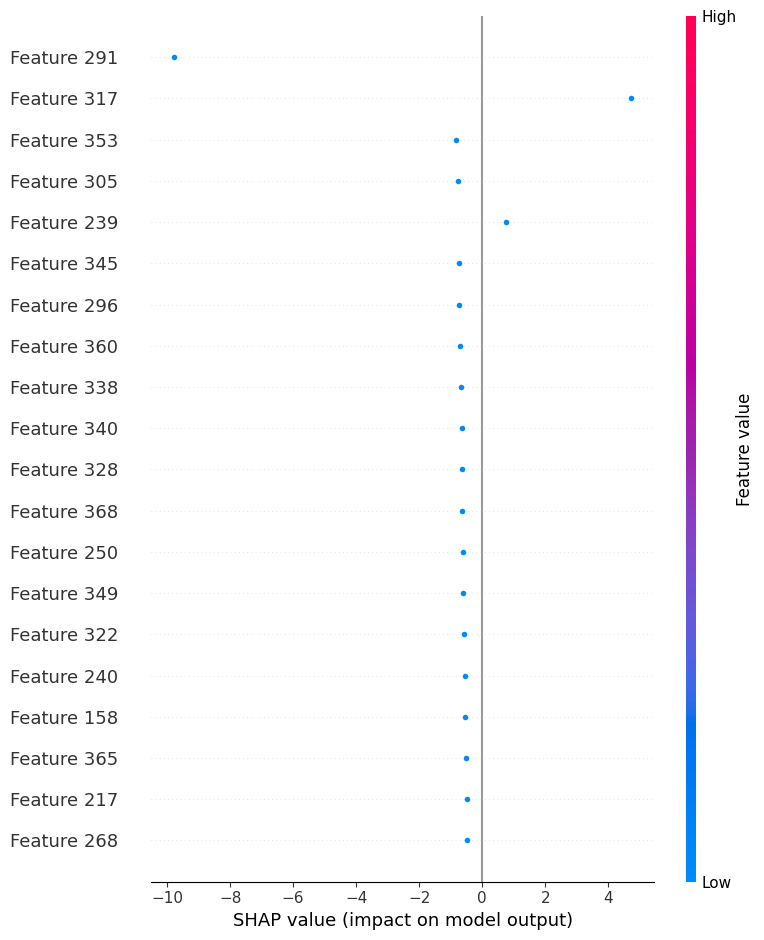

Generando gráfico para la clase  D


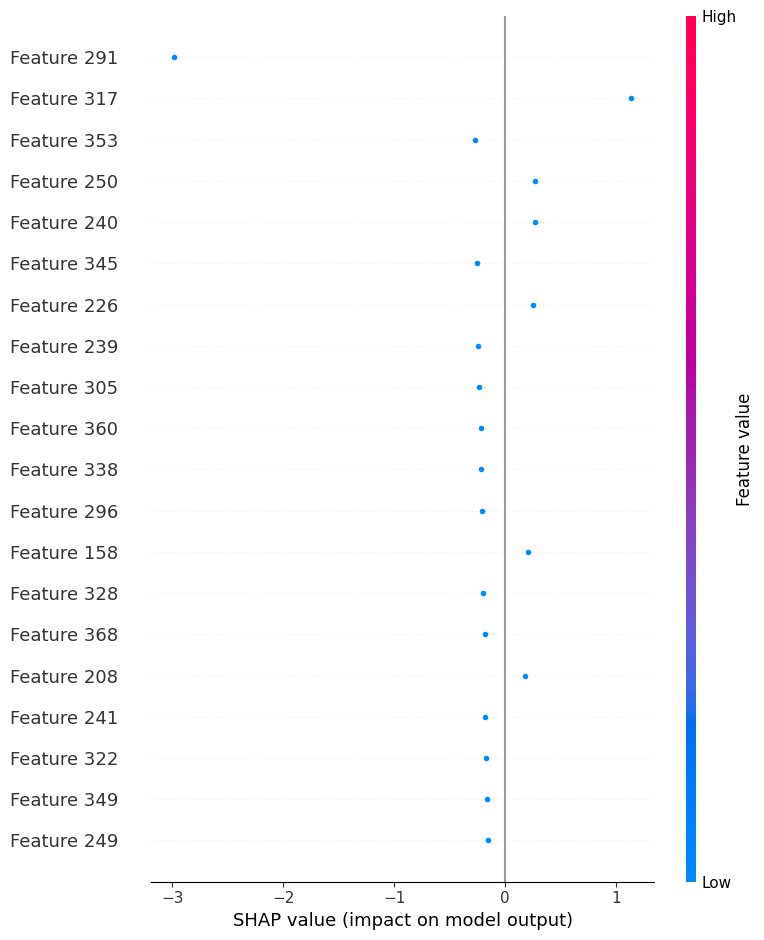

Generando gráfico para la clase  R


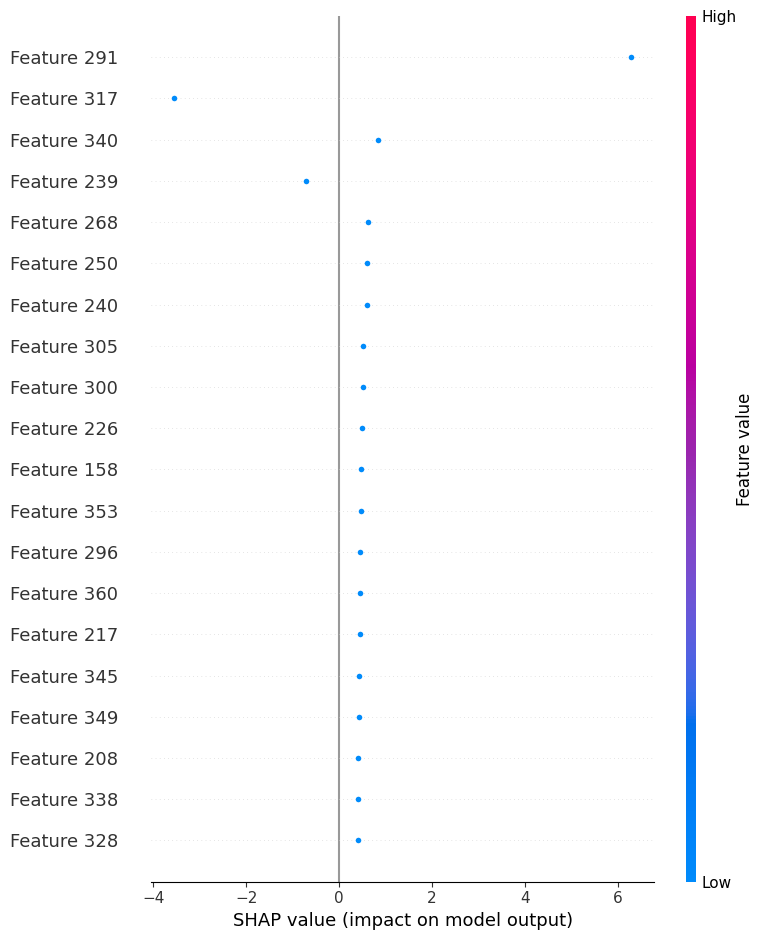

Generando gráfico para la clase  V


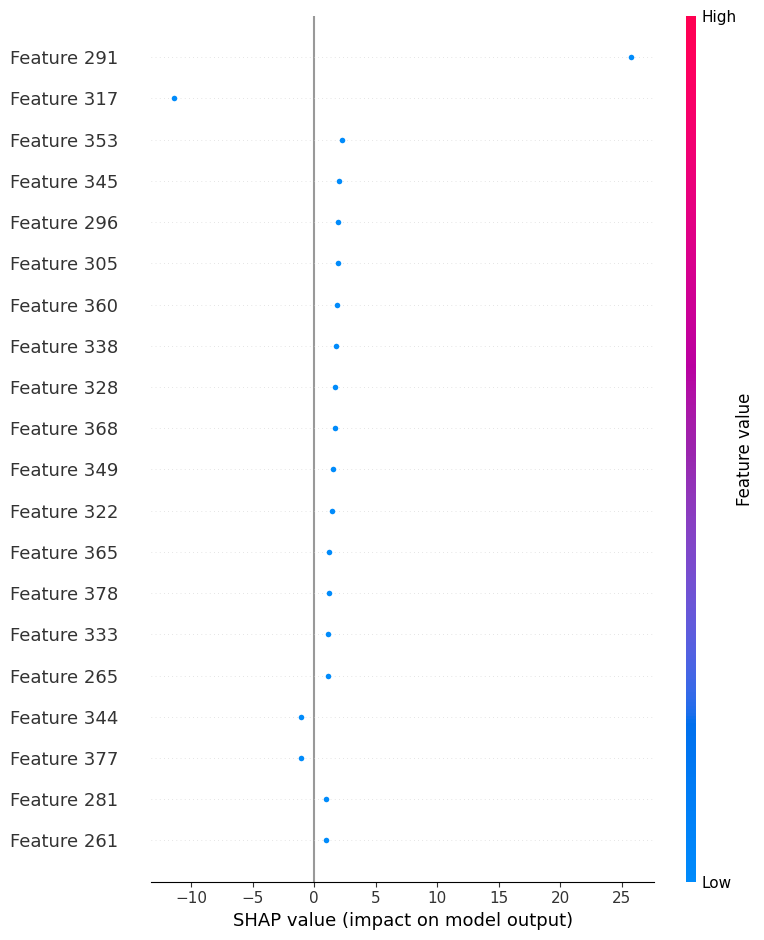

In [99]:
# Para las primeras 10 muestras
for class_idx in range(4):  # Asumiendo que hay 4 clases
    # Extraer la contribución de todas las características para esta clase en las primeras 10 muestras
    print("Generando gráfico para la clase ", label_encoder.classes_[class_idx])
    class_shap_values = np.array([shap_values[i][:, class_idx] for i in range(10)])  # Obtener los valores SHAP para cada una de las 10 muestras y la clase 'class_idx'

    # Visualizar los valores SHAP para esta clase en las primeras 10 muestras
    shap.summary_plot(class_shap_values[4:5], x_train[4:5])

Observamos los valores shap que obtiene la muestra [',___._.,..___,,,', '.._,_____..w,.u_', '.._.._.._._,,.,,', 'V'] para las 4 clases.
Como vemos, en las clases A y D , la característica 291 f3-4-c tiene valores shap negativos. Esto nos indica que la presencia de la operación en la muestra hace que el modelo tienda a no predecirla como A o D.
Para la clase R, la característica 291 f3-4-c tiene valores shap positivos. Esto quiere decir que la asuencia de la operacion en las muestras hace que el modelo tenga una alta probabilidad para predecir la muestra como R.
En el grafico de la clas V, también vemos como la característica 291 f3-4-c tiene valores shap positivos. Sin embargo la interpretación es distinta puesto que en este caso, es la presencia de esta operación lo que hace que el modelo tenga bastante tendencia a predecir la muestra como V.

Podemos observar que aunque la operación 'c' no aparece en la muestra, la característica 291 f3-4-c es de las más influyentes en el modelo a la hora de predecir. Esto nos indica que el modelo no solo tiene en cuenta la presencia de las operaciones en las muestras, si no tambien su ausencia, siendo en ciertos casos como para la clase R, que la ausencia de una operación es lo más influyente a la hora de predecir.

# **SHAP.KERNEL APLICADO A CNN**

## Funcion predict

In [47]:
#  realiza la predicción sobre un conjunto de datos 
def predict_cnn(x_train):
    best_cnn_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_conv_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_cnn_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Generamos la explicacion


Generando explicación para clase 'A'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: [',__.__.,_._,._._', '..,,_,__,.,u.w,.', '_.___,_d.r.._,,.', 'A']
  Muestra 2: ['.....__,...,.,_,', '_..u,w,,_.,____,', '..,,,,_d,r,_.._.', 'A']
  Muestra 3: [',_,_.,,._,,__._,', ',,,,,_u.w._..._.', ',d,r_..,,...,,,,', 'A']
  Muestra 4: [',._._,_,_.,,,.._', '...,,..u.w.__,,_', ',d.r.,,_.,._,,..', 'A']
  Muestra 5: ['.,._,,,..,._,_,.', '.,__..u.w,._,.,.', '.,._..,,_,.d.r..', 'A']
  Muestra 6: [',.,__..,.,._,.,,', ',___.,,,_.u,w_._', ',...,,,d.r,,,..,', 'A']
  Muestra 7: [',_,_,,...,_,_,,.', '_.._u.w,,__,,,_.', 'd.r,_..,_.,_,_..', 'A']
  Muestra 8: ['.__.__..,.,.._,_', ',__,..__.u,w._,.', '_,.d,r.,__,_._..', 'A']
  Muestra 9: ['.,_._,,_,,,_._,,', '__,___,u,w_,,_,,', '._._____d.r_,_,.', 'A']
  Muestra 10: ['._.,__,_..,._._,', '_,,,._.,.u,w,_,_', ',._,d,r___,,,_,_', 'A']


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
C:\Users\franm\AppData\Local\Temp\ipykernel_21452\2426225975.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(class_shap_values_cnn, x_subset_cnn, feature_names=feature_names_mapped)


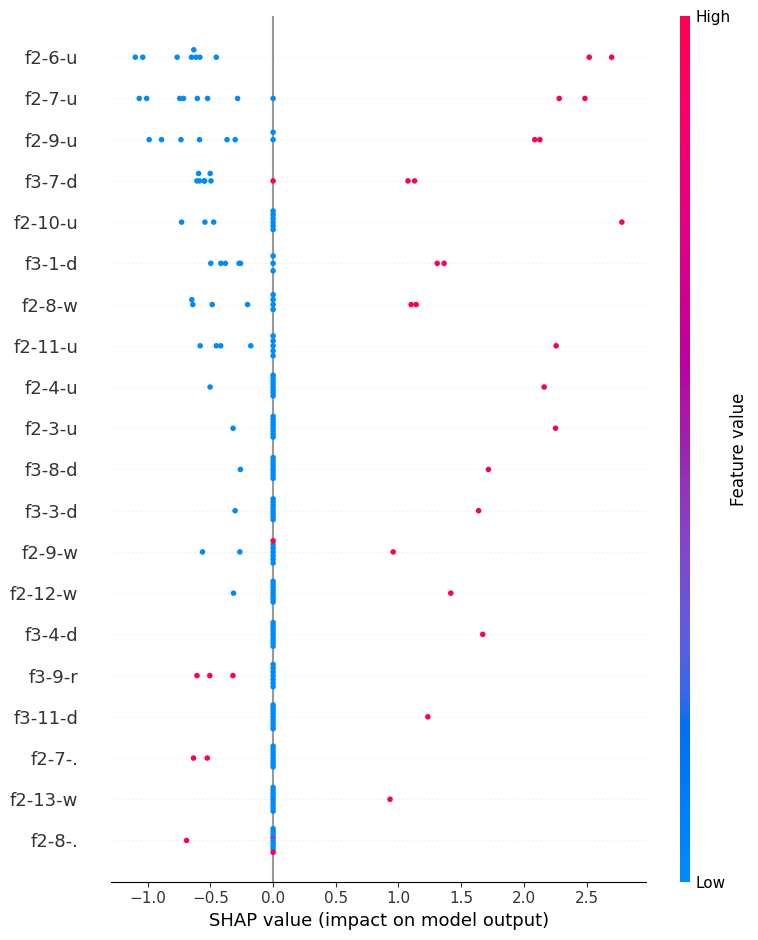


Generando explicación para clase 'D'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: [',.,___,..._,,.__', '._,__,...w,,,_,_', '.,._d,r,,__,,.._', 'D']
  Muestra 2: [',,_,.._,,,.._.,_', '_,w...___..____.', '._.,.d_r_,..,,..', 'D']
  Muestra 3: ['.._,,_,__,.,__,,', '.,.._,,.__.,._w_', ',,d_r,.__,..,.,_', 'D']
  Muestra 4: ['._.____..,___.,_', '.,.,___,.,..,,,.', '__.,.,_,,,d_r._,', 'D']
  Muestra 5: ['.,.____..,.._,_,', '.._._._..__.,,_.', 'd,r,.,_,.__._._,', 'D']
  Muestra 6: [',_,_,.._.,._.,._', '__..,...____.w_,', ',,...,____.d.r..', 'D']
  Muestra 7: [',,_...,.._,_,..,', ',,__,,__.._._,._', ',__.._d.r__.,_,_', 'D']
  Muestra 8: ['.,,_,.__,,_,_.._', ',_w.,_.,_.,,._.,', ',_,._..,___.d_r.', 'D']
  Muestra 9: ['.....,.,.,_.,,,.', '_,,.,..,_...._,.', ',._.__d,r._._._.', 'D']
  Muestra 10: ['_..,,..,,_,,,_,_', '_.____..,_,.__w,', '..,.d,r,_,.._,,.', 'D']


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


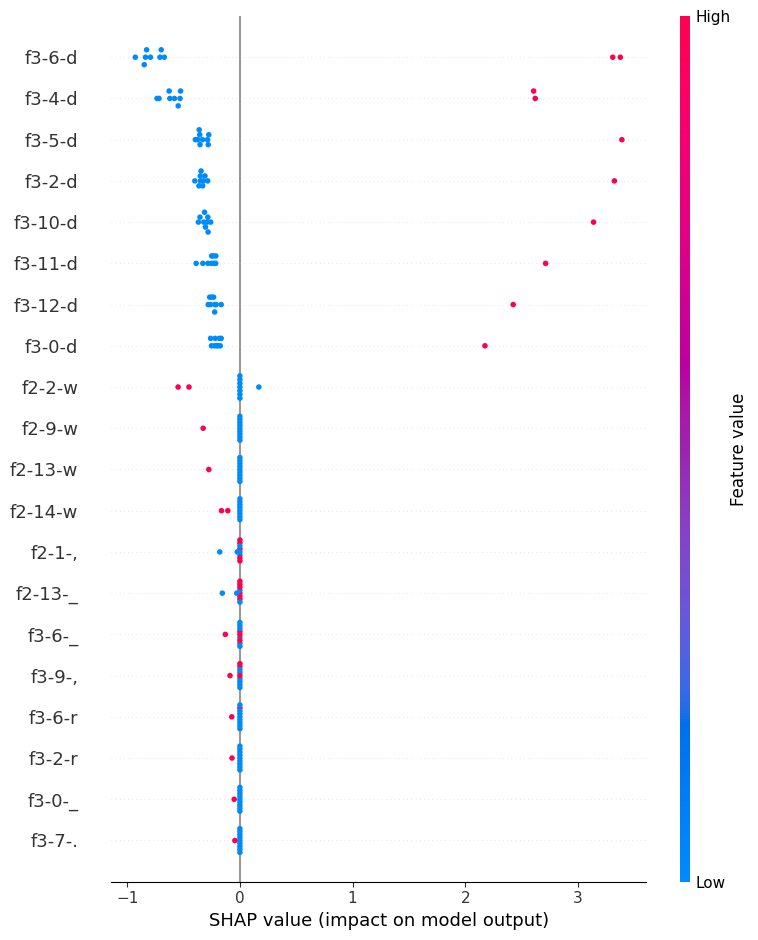


Generando explicación para clase 'R'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['..,__,.._.,_,.._', '__._..__._..__._', '__._,..__r,_.,_.', 'R']
  Muestra 2: [',.,._,.__,,__.,,', '..___._.,.u_w..,', '_..__,_,,,__r_..', 'R']
  Muestra 3: [',._,,,,.,_,.,..,', 'w.__,._._.____..', '__,,.,_,r.......', 'R']
  Muestra 4: [',_.._.,_..,_.__,', '___,,..,,___.,__', ',_,_,r.,.,__....', 'R']
  Muestra 5: [',,_._.__,_.,.,._', ',,,,.,..w_u,.,._', '.._.___.,_.,__r.', 'R']
  Muestra 6: ['__.,...__,_,.___', '_,.__,,,,u,w,__.', '_,__.r._._.___,_', 'R']
  Muestra 7: ['_._..,_.,.._._..', '..,,.u,w_,.,,.__', '.,.__,,r...,.,_.', 'R']
  Muestra 8: ['.,,.,,.....,._..', ',,w.u__.,.,__.,.', ',,_.._,r.___,_,,', 'R']
  Muestra 9: ['.._.____,_._,_.,', 'u_w._,,,____,_..', '_r____.,.,,.,.,_', 'R']
  Muestra 10: [',._.,...,.._,,.,', '._.,,.__,._,_._,', ',..r__..._,,..__', 'R']


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


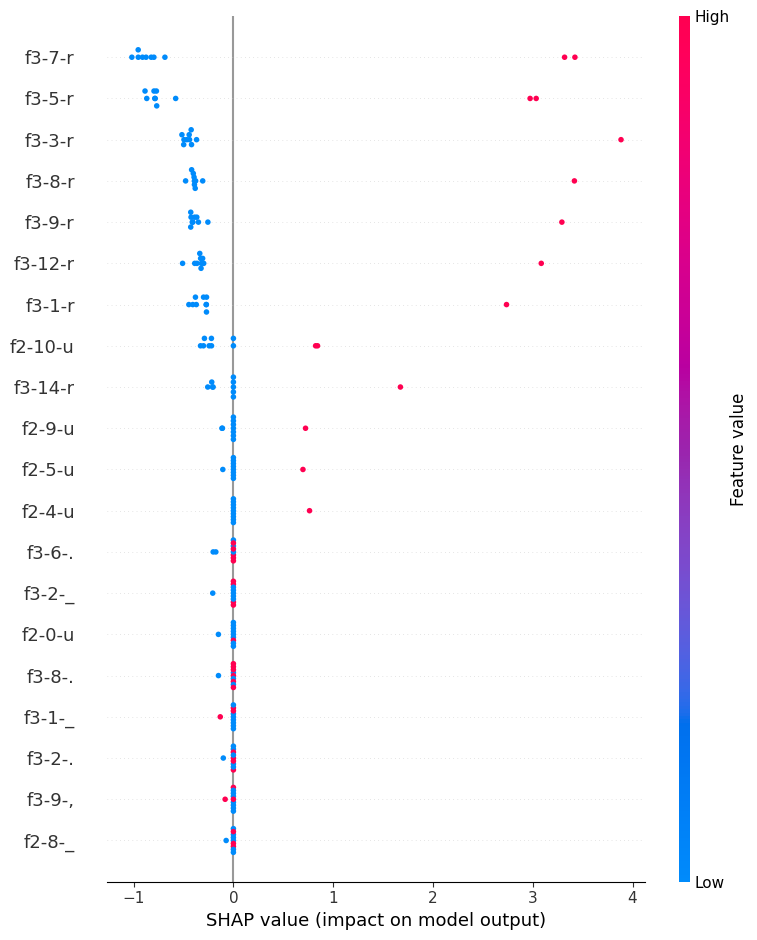


Generando explicación para clase 'V'
 Muestras pasadas al explainer: (10, 384)
 Muestras pasadas al explainer (decodificadas):
  Muestra 1: ['__.,,,.,__,,..,,', 'w,u._,,_.,,.._._', '_.c_r,..__,_,.,,', 'V']
  Muestra 2: ['__._,_,.._..,.,_', '__..w_u,.,_.,._.', '..,d,r__..._..__', 'V']
  Muestra 3: ['.,,._,_,,.,,,_._', '..,_._,,._.,,_..', ',,____,.c.r___,,', 'V']
  Muestra 4: [',__,._,.___._.__', ',,.,__,._,,,_._,', ',.,c_r.,,,,_,__,', 'V']
  Muestra 5: ['.....__,.....__.', '__.w.._,._,._,,.', '..__c,r_,_,_..,.', 'V']
  Muestra 6: ['._,.,_,._.._,,_.', ',_.,..,__u_w_..,', '.,_.,_,,_____.,.', 'V']
  Muestra 7: ['__..,,______._.,', ',,.,._w,,_.,.,._', '__,_,.,_.,....,_', 'V']
  Muestra 8: [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', 'V']
  Muestra 9: [',..,__,,_._,.,,.', 'u_w...___,_.____', ',__,_.,,,_._.,_.', 'V']
  Muestra 10: ['__,,__.,._._,_,_', '_.,.,_,,_.w.__,.', '..,_,..__,__._,_', 'V']


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


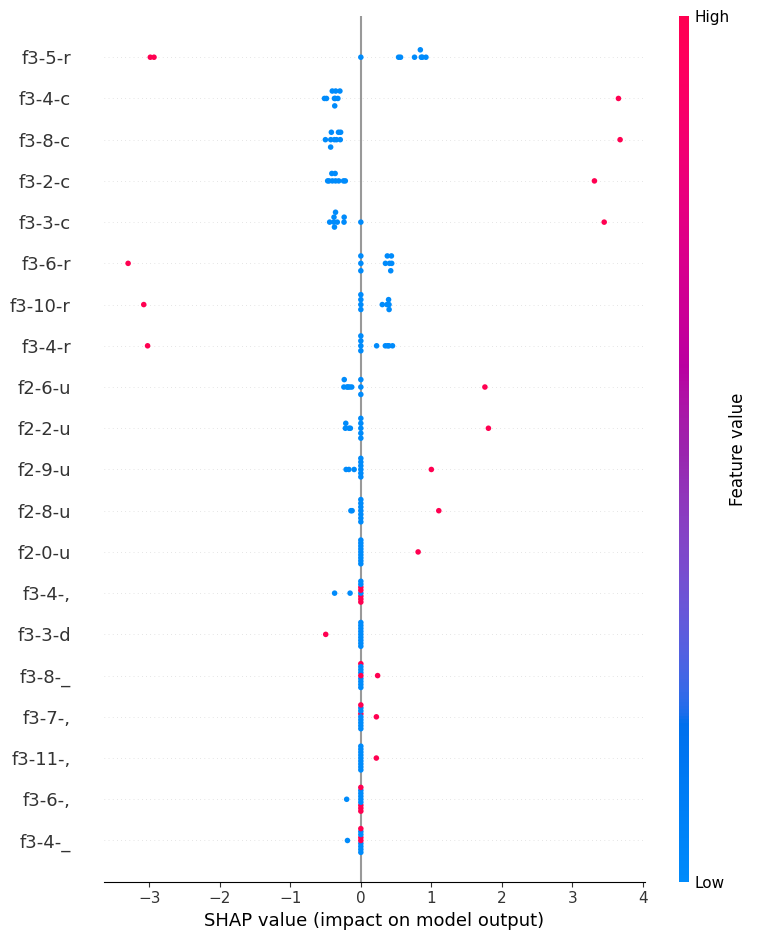

In [48]:
import shap
import numpy as np

# 💡 Nombres de clases
class_names = ["A", "D", "R", "V"]
n_samples = 10  # Número de muestras por clase

for class_idx in range(4):
    class_name = class_names[class_idx]
    print(f"\n==============================")
    print(f"Generando explicación para clase '{class_name}'")
    print(f"==============================")

    # 🟢 Buscar muestras de la clase en el conjunto de test
    indices = np.where(y_test == class_idx)[0][:n_samples]
    x_subset_cnn = x_test[indices]

    print(f" Muestras pasadas al explainer: {x_subset_cnn.shape}")
    print(f" Muestras pasadas al explainer (decodificadas):")
    for i, idx in enumerate(indices):
        print(f"  Muestra {i+1}: {test_original[idx]}")

    #  Crear el explainer con muestras solo de esa clase
    explainer_cnn = shap.KernelExplainer(predict_fn_SHAP_CNN, x_subset_cnn)

    #  Explicamos las mismas muestras del test
    shap_values_cnn = explainer_cnn.shap_values(x_subset_cnn)

    #  SHAP de la clase actual
    class_shap_values_cnn = np.array([shap_values_cnn[i][:, class_idx] for i in range(n_samples)])

    #  Mostrar resumen
    shap.summary_plot(class_shap_values_cnn, x_subset_cnn, feature_names=feature_names_mapped)


ANÁLISIS GRAFICO CLASE A (VIOLACION DE ATOMICIDAD  ‘u’‘w’ ‘d’‘r’)

Como podemos observar las características con valores shap positivo son las siguientes: 
166 f2-4-u   
276 f3-2-d
364 f3-13-d
191 f2-7-w
230 f2-12-u
Podemos decir que las operaciones 'u 'd y 'w' son muy influyentes a la hora de que el modelo prediga las muestras con estas operaciones como de clase A. Esto cuadra bastante ya que estas operaciones forman la secuancia (‘u’‘w’‘d’‘r’) que es clave para que una muestra sea A.

Descata la caracterísitica 291 f3-4-c con valores shap negativos. Esto nos indica que la presencia de esta operacion en las muestras hace que el modelo tenga una cierta probabilidad para predecir la muestra como A. Lo es una carácterística muy influyente puesto que en el gráfico es de las últimas pero es un factor que el modelo también cosidera.

También llama la atención las siguientes características que tienen valores shap negativos. Soprende puesto que es una operacion que forma parte de la secuencia  (‘u’‘w’‘d’‘r’) que es clave para que una muestra sea A. POr lo que podemos interpretar que noe s la presencia de esta operación lo que hace que el modelo no prediga la muestra como A, sino su ausencia. Es decir que una muestra no contenga la op 'r' es uno de los factores más influyentes a la h de que el modelo no prediga la clase como A.
317 f3-7-r
349 f3-11-r
365 f3-13-r
341 f3-10-r
269 f3-1-r



166 f2-4-u
276 f3-2-d
317 f3-7-r
364 f3-13-d
349 f3-11-r
191 f2-7-w
365 f3-13-r
341 f3-10-r
340 f3-10-d
182 f2-6-u
357 f3-12-r
158 f2-3-u
230 f2-12-u
320 f3-8-,
328 f3-9-,
269 f3-1-r
336 f3-10-,
291 f3-4-c
314 f3-7-_
304 f3-6-,

------------------------------------------------------------------------------------------------------------------------------------------------------

ANÁLISIS GRAFICO CLASE D (DEADLOCK no-op  ‘d’‘r’ / 'w'  ‘d’‘r’)

Como vemos en el grafico, las características mas influyentes con valores shap positivos son 276 y 364 con la operación 'd'. Esto indica que su presencia en la muestra hace que el modelo tenga alta probabilidad para predecirla como D. Esto tienen bastante sentido puesto que es una operación que aparece en las dos secuencias de operaciones clave para que la muestra sea de clase D.

Las siguientes caracteristicas más influyentes son 166 y 230 pero esta vez con valores shap negativos. Ambas características son de la op 'u'. Teniendo en cuenta esto, podemos llegar a la conclusión de que la presencia de esta operación es  muy influyente para el modelo a la hora de NO predecir la muestra como D. esto tiene mucho sentido pues es una operación que NO aparece en las dos secuencias de operaciones clave para que la muestra sea de clase D.

Llama la atención la característica 191 con valores shap negativos y que corresponde a la operación w. ¿?¿?¿?¿?¿?¿?¿?

166 f2-4-u
276 f3-2-d
364 f3-13-d
230 f2-12-u
158 f2-3-u
182 f2-6-u
340 f3-10-d
191 f2-7-w
222 f2-11-u
268 f3-1-d
150 f2-2-u
300 f3-5-d
317 f3-7-r
199 f2-8-w
142 f2-1-u
206 f2-9-u
308 f3-6-d
178 f2-6-_
134 f2-0-u
349 f3-11-r

------------------------------------------------------------------------------------------------------------------------------------------------------

ANÁLISIS GRAFICO CLASE R (CONDICIÓN DE CARRERA no-op /'w' / 'u''w' /'w''u'/ + 'r') no hacer 'c''r' para comprobar si se ha escrito y se puede leer correctamente sin carrera

Onservamos en el gráfico las siguientes características con valores shap positivos:
317 f3-7-r
349 f3-11-r
365 f3-13-r
341 f3-10-r
357 f3-12-r
269 f3-1-r
301 f3-5-r
373 f3-14-r
Todas ellas con la operación 'r', lo que nos indica que la presencia de esta operación en las muestras es un factor muy influyente a la h de que el modelo la prediga como R. Esto tiene mucho sentido ya que la operación 'r' está presente en las 4 secuencias que clasifican la muestra como clase R. Por lo tanto su presencia obvamente es muy influyente. 

Las siguientes carácterísiticas tienen valores shap negativos:
276 f3-2-d
291 f3-4-c
364 f3-13-d
Esto indica que la presencia de las operaciones 'd' y 'c' hace que el modelo tenga cierta tendencia a No predecir el modelo como R. Esto cuadra bastante ya que son op. que no aparecen en las 4 secuencias que clasifican la muestra como clase R. Por lo tanto su presencia obvamente es muy relevante e influyente. 


Los resultados obtenidos en esta gráfica son muy intuituvos y obvios. No soprende ni llama la atención ninguna característica.

317 f3-7-r
349 f3-11-r
276 f3-2-d
365 f3-13-r
341 f3-10-r
357 f3-12-r
269 f3-1-r
291 f3-4-c
364 f3-13-d
301 f3-5-r
340 f3-10-d
285 f3-3-r
333 f3-9-r
268 f3-1-d
309 f3-6-r
300 f3-5-d
277 f3-2-r
261 f3-0-r
308 f3-6-d
373 f3-14-r


--------------------------------------------------------------------------------------------------------------------------------------------------------------------

ANÁLISIS GRAFICO CLASE V (No error. Cuando f3 contiene todo no-ops o la secuencia 'c''r'   y cuando 'w''u' 'd''r')

Las características con valores shap negativos son las siguientes: (para la clase R aparecen varias pero con valoress positivos)
317 f3-7-r
349 f3-11-r
365 f3-13-r
301 f3-5-r
341 f3-10-r
269 f3-1-r
357 f3-12-r
373 f3-14-r
Todas ellas con la operación 'r'. Al ser una operacion que está presente en todas secuencias que clasifican la muestra como clase V. No tendría sentido pensar que su presencia en la muestra hace que el modelo No la clasifique como V. Por lo que entendemos que es la ausencia de la operación lo que hace que el modelo NO la clasifique como V. Es decir, para el modelo es una operacion tan relevante e influtente que su ausencia es la que realmente influye más. En este caso para NO clasificar la muestra como V.


Las caracteríticas con valores shap positvos son:
291 f3-4-c
166 f2-4-u
230 f2-12-u
'c' y 'u' son op. que  aparecen en las secuencias que clasifican la muestra como clase V. Por lo tanto su presencia obvamente es muy relevante e influyente a la hora de que el modelo prediga la muestra como V. 


317 f3-7-r
349 f3-11-r
291 f3-4-c
365 f3-13-r
301 f3-5-r
341 f3-10-r
269 f3-1-r
357 f3-12-r
309 f3-6-r
285 f3-3-r
166 f2-4-u
230 f2-12-u
333 f3-9-r
277 f3-2-r
314 f3-7-_
328 f3-9-,
373 f3-14-r
158 f2-3-u
320 f3-8-,
261 f3-0-r




-------------NO salen f1. Porque a veces si una operacion aparece much en todas las secuancias, hay veces que el modelo hace que sea mas influtente mas su ausencia que su presencia 